In [1]:
import numpy as np
import matplotlib.pyplot as plt

Defining functions for indexing of the helicene's sites.

In this Notebook, the sites of the helicene molecule are labeled by two indices $(i_{hex}, i_{site})$. Here, i_hex numbers the hexagon to which the site belongs, such that $i_{hex} = 0$ corresponds to the first hexagon from the left lead, until $i_{hex} = N_{hex} - 1$, where $N_{hex}$ is the total number of hexagons. The helicene molecule can be decomposed into $N_{hex}$ groups of 4 sites, which correspond to the label $i_{site}$.  in which the label $i_{site}=0$ corresponds to the left-most site on the inner helix, while $i_{site} = 1$ corresponds to the left-most site of the middle helix. The sites $i_{site} = 2,3$ correspond to the left and right sites on the outer helix, respectively. The sites $i_{site} = 0,1$ on the subsequent hexagon make up the remaining corners of the incomplete hexagon.

In [2]:
def index_1D_per(Struct_dims):
    """
    Input:
        Struct_dims = [N1, N_struct], where:
            N1 :  number of times the structure is repeated
            N_struct :  number of elements within a single repeated unit
    """
    N1, N_struct = int(Struct_dims[0]), int(Struct_dims[1])
    N_tot = N1*N_struct
    ind_arr = np.arange(0,N_tot)
    ind_arr_res = np.reshape(ind_arr, newshape = [N1, N_struct])
    return ind_arr.astype(int), ind_arr_res.astype(int)

def inv_index_1D_per(Struct_dims):
    N1, N_struct = int(Struct_dims[0]), int(Struct_dims[1])
    ind_dim0 = np.expand_dims(np.arange(0, N1), axis = 1)
    ind_dim = np.repeat(ind_dim0, repeats = N_struct, axis = 1)
    ind_dim = np.reshape(ind_dim, newshape = [N1*N_struct])
    
    ind_struct0 = np.arange(0,N_struct)
    ind_struct = np.array(list(ind_struct0)*N1)
    
    ind_store = np.zeros([N1*N_struct, 2])
    ind_store[:,0] = ind_dim; ind_store[:,1] = ind_struct
    return ind_store.astype(int)


Import the function for the higher-order integration of functions
### Note: ### 
The argument of sys.path.append() should be changed from 'C:\\Users\janbr\Downloads\MEP files\Code') to the location where this file is stored on your device.

Also, change the file's name from "N_order_integrator_only_functions" if the file's name has changed

The code can also be run without this file, which will however reduce the quality/resolution of the obtained output. This can be achieved by replacing all integrate_n_flipaxes() in the code with delta_E \* np.sum(-1j*G_less_store, axis = 0), where delta_E = np.abs(e_arr[1] - e_arr[0]) is the resolution of the respective energy-array.

In [3]:
import sys
sys.path.append('C:\\Users\janbr\Downloads\MEP files\Code')    

from N_order_integrator_only_functions import integrate_n_flipaxes

In [102]:
    
N_hex = 5
Struct_mol_dims = [N_hex,4]
H_shape = Struct_mol_dims + [2] + Struct_mol_dims + [2]

I_mol = index_1D_per(Struct_mol_dims)[1]; Iinv_mol = inv_index_1D_per(Struct_mol_dims)
Iinv_mol[:,1]

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

Defining a function for generating the positions of helicene molecule's sites 

In [169]:
def get_pos(pitch_hel, Phi0 = np.pi/3, dPhi0 = 19.1*np.pi/180):
    R_arr = np.zeros(Struct_mol_dims)
    R_arr[:,0] = 1.4
    R_arr[:,1] = 2
    R_arr[:,2] = np.sqrt(7)
    R_arr[:,3] = np.sqrt(7)


    Phi_vals = Phi0*np.arange(0,Struct_mol_dims[0])
    Phi_arr = np.zeros(Struct_mol_dims)
    Phi_arr[:,0] = Phi_vals
    Phi_arr[:,1] = Phi_vals
    Phi_arr[:,2] = Phi_vals + dPhi0
    Phi_arr[:,3] = Phi_vals + Phi0 - dPhi0

    Pos_arr = np.zeros([3] + Struct_mol_dims)
    Pos_arr[0] = R_arr*np.cos(Phi_arr)
    Pos_arr[1] = R_arr*np.sin(Phi_arr)
    Pos_arr[2] = pitch_hel/(2*np.pi)*(Phi_arr)
    
    return Pos_arr



#### On-site energies, tunnel and SOI couplings

The links between sites are assumed to be periodic with the hexagons. This periodic nature is incorporated into the notation (i,j,k) used for the tunnel and SOI coupling links, where (i,j,k) corresponds to all links between site j on the (i+N)-th hexagon and the site k on the N-th hexagon (for any N s.t. N, i+N within the molecule)


In [224]:
E_site = 0

#Links between sites are assumed to be periodic with the hexagons
#This periodic nature is incorporated into the notation (i,j,k) used for the tunnel and SOI coupling links
#The notation (i,j,k) corresponds to all links between site j on the (i+N)-th hexagon and the site k on the N-th hexagon (for any N s.t. N, i+N within the molecule)

Tunnel_ind = ((0,1,0), (0,2,1), (0,3,2), (1,1,3), (1,0,0))
Tunnel_vals = 0.1*np.array([2,3,1,3,2.5])

SOI_ind = ((0,1,0), (0,2,1), (0,3,2), (1,1,3), (1,0,0))
SOI_lambda = np.array([0.5,0.5,0.5,0.5,0.5], dtype = 'complex128')
E_const = np.array([1,0,1], dtype = 'complex128')

In [194]:
def generate_H(Pos_arr, E_const):
    H_shape = Struct_mol_dims + [2] + Struct_mol_dims + [2]
    sigma0 = np.eye(2,2,k=0)

    H0_test = np.zeros(H_shape, dtype = 'complex128')
    
    E_onsite_arr = np.zeros(H_shape, dtype = 'complex128')
    Tau_arr = np.zeros(H_shape, dtype = 'complex128')
    SOI_arr = np.zeros(H_shape, dtype = 'complex128')

    Pauli_vec = np.zeros([2,2,3], dtype = 'complex128')

    Pauli_vec[:,:,0] = np.array([[0,1],[1,0]])
    Pauli_vec[:,:,1] = np.array([[0,-1j],[1j,0]])
    Pauli_vec[:,:,2] = np.array([[1,0],[0,-1]])

    #print(H0_test.shape)

    diag0 = np.arange(0,H0_test.shape[0])

    for i in range(0,H0_test.shape[1]):
        E_onsite_arr[diag0,i,:,diag0,i,:] = E_site*sigma0

    for i in range(0, len(Tunnel_ind)):
        Hex_ind = Tunnel_ind[i][0]
        Site_ind1, Site_ind2 = Tunnel_ind[i][1], Tunnel_ind[i][2]
        if Hex_ind == 0:
            diag_i1 = diag0; diag_i2 = diag0
        if Hex_ind != 0:
            diag_i1 = diag0[Hex_ind:]; diag_i2 = diag0[:(-Hex_ind)]
        Tau_arr[diag_i1, Site_ind1, :, diag_i2, Site_ind2] = Tunnel_vals[i]*sigma0
        Tau_arr[diag_i2, Site_ind2, :, diag_i1, Site_ind1] = np.conj(np.transpose(Tunnel_vals[i]*sigma0))



    HSOI_store = []
    for i in range(0, len(SOI_ind)):
        Hex_ind = SOI_ind[i][0]
        Site_ind1, Site_ind2 = SOI_ind[i][1], SOI_ind[i][2]
    #    print(Site_ind1);print(Site_ind2)
        if Hex_ind == 0:
            dPosi = (Pos_arr[:,:,Site_ind1] - Pos_arr[:,:,Site_ind2])
            dPosi_norm = np.sqrt(np.sum(dPosi**2, axis = 0))
            dPosi = np.copy(dPosi/dPosi_norm)
        if Hex_ind != 0:
            dPosi = Pos_arr[:,Hex_ind:,Site_ind1] - Pos_arr[:,:(-Hex_ind),Site_ind2]
            dPosi_norm = np.sqrt(np.sum(dPosi**2, axis = 0))
            dPosi = np.copy(dPosi/dPosi_norm)
        dPosi = np.cross(np.swapaxes(dPosi, 0, -1), E_const)  
        dPosi_ext = np.repeat(np.expand_dims(dPosi, axis = -2), 2, axis = -2)
        dPosi_ext = np.repeat(np.expand_dims(dPosi_ext, axis = -2), 2, axis = -2)

        HSOI_i = -1j*SOI_lambda[i]*np.sum(Pauli_vec*dPosi_ext, axis = 3)
        HSOI_store.append(HSOI_i)    


    for i in range(0, len(SOI_ind)):
        Hex_ind = SOI_ind[i][0]
        Site_ind1, Site_ind2 = SOI_ind[i][1], SOI_ind[i][2]
       # print(Site_ind1);print(Site_ind2)
        if Hex_ind == 0:
            diag_i1 = diag0; diag_i2 = diag0
        if Hex_ind != 0:
            diag_i1 = diag0[Hex_ind:]; diag_i2 = diag0[:(-Hex_ind)]
      #      print(diag_i1)
        SOI_arr[diag_i1,Site_ind1,:,diag_i2,Site_ind2,:] = HSOI_store[i]
        SOI_arr[diag_i2,Site_ind2,:,diag_i1,Site_ind1,:] = np.conj(np.swapaxes(HSOI_store[i],-1,-2))
    
    H_tot = E_onsite_arr + Tau_arr + SOI_arr
    return H_tot, E_onsite_arr, Tau_arr, SOI_arr


    

#### On-site Coulomb interactions
The strengths of the sites' Coulomb interactions are assumed to be periodic w.r.t. the hexagons, i.e. $U_{i_{hex},i_{site}} = U_{i_{site}}$. The values of the Coulomb interactions are defined in the array U_vals for $i_{site} = 0,1,2,3$

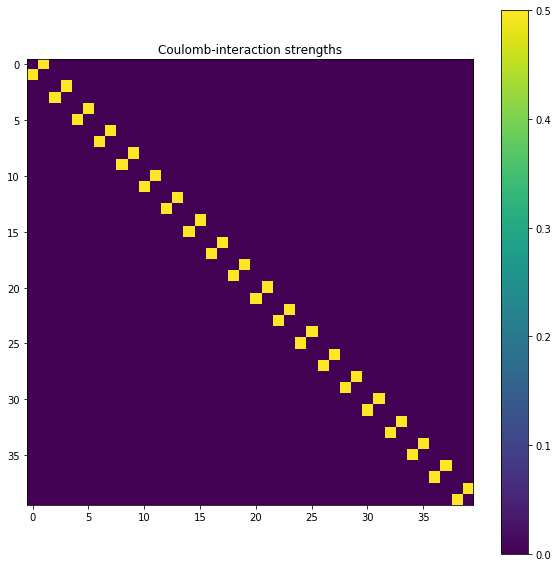

In [251]:
U_onsite_arr = np.zeros(H_shape, dtype = 'complex128')
U_vals = np.array([0.5]*4)
Sigma_x = np.array([[0,1],[1,0]], dtype = 'complex128')

for i in range(0,len(U_vals)):
    U_vals_i = U_vals[i]
    U_onsite_arr[Iinv_mol[:,0],i,:,Iinv_mol[:,0],i,:] = U_vals_i*Sigma_x
    
plt.figure(figsize = (10,10))
U_onsite_arr_res = np.reshape(U_onsite_arr,[2*H_shape[0]*H_shape[1]]*2)
plt.title('Coulomb-interaction strengths');plt.imshow(np.real(U_onsite_arr_res));plt.colorbar()

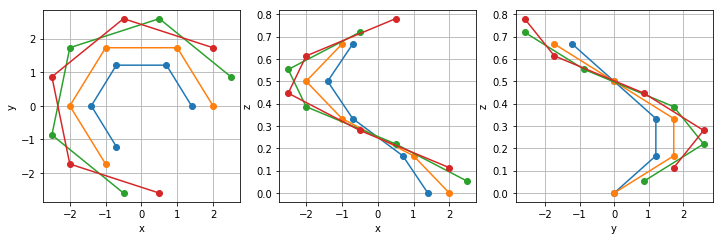

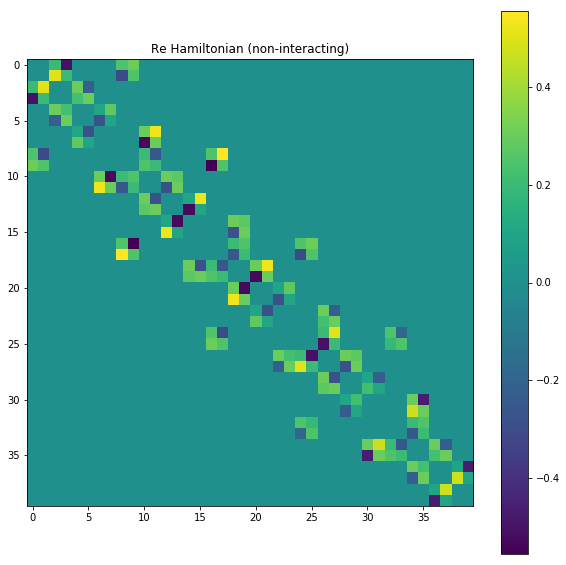

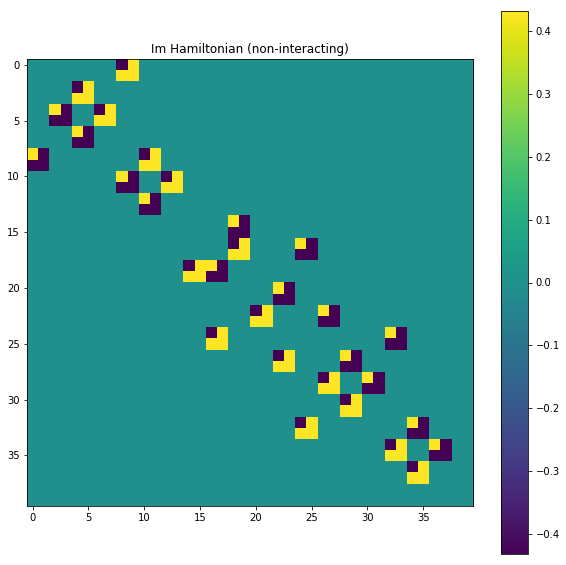

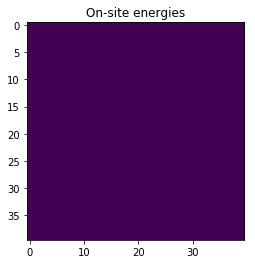

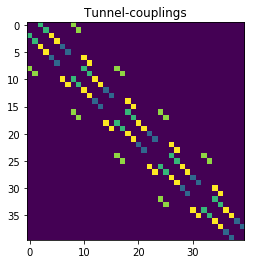

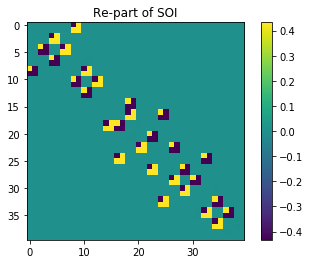

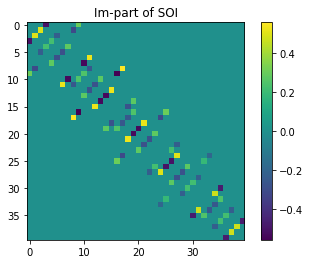

In [249]:
Pos_arr = get_pos(1)

H0, E_onsite_arr, Tau_arr, SOI_arr = generate_H(Pos_arr, np.array([1,0,1], dtype = 'complex128'))

Hres = np.reshape(H0, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
E_onsite_arr_res = np.reshape(E_onsite_arr, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
Tau_arr_res = np.reshape(Tau_arr, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
SOI_arr_res = np.reshape(SOI_arr, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])

Id_res = np.eye(2*H_shape[0]*H_shape[1], 2*H_shape[0]*H_shape[1], dtype = 'complex128')

plt.figure(figsize = (12,12))
plt.subplot(331);
for i in range(0,Struct_mol_dims[1]):
    plt.plot(Pos_arr[0,:,i], Pos_arr[1,:,i],'-o')
plt.xlabel('x');plt.ylabel('y');plt.grid()
plt.subplot(332);
for i in range(0,Struct_mol_dims[1]):
    plt.plot(Pos_arr[0,:,i], Pos_arr[2,:,i],'-o')
plt.xlabel('x');plt.ylabel('z');plt.grid()
plt.subplot(333);
for i in range(0,Struct_mol_dims[1]):
    plt.plot(Pos_arr[1,:,i], Pos_arr[2,:,i],'-o')
plt.xlabel('y');plt.ylabel('z');plt.grid();plt.show()

plt.figure(figsize = (10,10))
plt.title('Re Hamiltonian (non-interacting)');plt.imshow(np.real(np.reshape(H0, [N_hex*4*2, N_hex*4*2])));plt.colorbar();plt.show()

plt.figure(figsize = (10,10))
plt.title('Im Hamiltonian (non-interacting)');plt.imshow(np.imag(np.reshape(H0, [N_hex*4*2, N_hex*4*2])));plt.colorbar();plt.show()

plt.title('On-site energies');plt.imshow(np.real(E_onsite_arr_res));plt.show()
plt.title('Tunnel-couplings');plt.imshow(np.real(Tau_arr_res));plt.show()
plt.title('Re-part of SOI');plt.imshow(np.imag(SOI_arr_res));plt.colorbar();plt.show()
plt.title('Im-part of SOI');plt.imshow(np.real(SOI_arr_res));plt.colorbar();plt.show()

#### Leads coupled to the molecule

The leads are connected to the sites specified in lead_conns_L/R. Here, Gamma_L/R[conn_tot_down/up] is set equal to the coupling strength between molecule and leads.

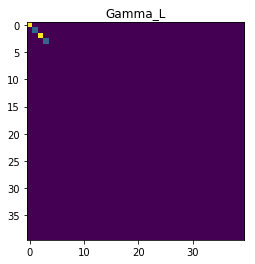

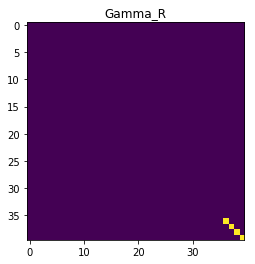

In [250]:
lead_conns_L = [(0,0),(0,1)]
lead_conns_R = [(-1,-1),(-1,-2)]

H_shape = Struct_mol_dims + [2] + Struct_mol_dims + [2]

Gamma_L = np.zeros(H_shape, dtype = 'complex128')
Gamma_R = np.zeros(H_shape, dtype = 'complex128')

Spin_proj_down = np.zeros(H_shape, dtype = 'complex128')
Spin_proj_up = np.zeros(H_shape, dtype = 'complex128')

Spin_proj_down[Iinv_mol[:,0], Iinv_mol[:,1], 0, Iinv_mol[:,0], Iinv_mol[:,1], 0] = 1
Spin_proj_up[Iinv_mol[:,0], Iinv_mol[:,1], 1, Iinv_mol[:,0], Iinv_mol[:,1], 1] = 1

Spin_res_down = np.reshape(Spin_proj_down, [Spin_proj_down.shape[0]*Spin_proj_down.shape[1]*2, Spin_proj_down.shape[3]*Spin_proj_down.shape[4]*2])
Spin_res_up = np.reshape(Spin_proj_up, [Spin_proj_up.shape[0]*Spin_proj_up.shape[1]*2, Spin_proj_up.shape[3]*Spin_proj_up.shape[4]*2])

for i in range(0,len(lead_conns_L)):
    conn_i = lead_conns_L[i]
    conn_tot_down = (conn_i + (0,) + conn_i + (0,))
    conn_tot_up = (conn_i + (1,) + conn_i + (1,))
    Gamma_L[conn_tot_down] = 0.75
    Gamma_L[conn_tot_up] = 0.25

for i in range(0,len(lead_conns_R)):
    conn_i = lead_conns_R[i]
    conn_tot_down = (conn_i + (0,) + conn_i + (0,))
    conn_tot_up = (conn_i + (1,) + conn_i + (1,))
    Gamma_R[conn_tot_down] = 0.5
    Gamma_R[conn_tot_up] = 0.5
    

Gamma_L_res = np.reshape(Gamma_L, [Gamma_L.shape[0]*Gamma_L.shape[1]*2,Gamma_L.shape[3]*Gamma_L.shape[4]*2])
Gamma_R_res = np.reshape(Gamma_R, [Gamma_R.shape[0]*Gamma_R.shape[1]*2,Gamma_R.shape[3]*Gamma_R.shape[4]*2])

plt.title('Gamma_L');plt.imshow(np.real(Gamma_L_res));plt.show()
plt.title('Gamma_R');plt.imshow(np.real(Gamma_R_res));plt.show()

Sigma_tot = -1j/2*(Gamma_L + Gamma_R)
Sigma_tot_res = np.reshape(Sigma_tot, [Sigma_tot.shape[0]*Sigma_tot.shape[1]*2,Sigma_tot.shape[3]*Sigma_tot.shape[4]*2])



#### Functions for self-consistently obtaining the occupations

In [200]:
def GF_ret(E, n_arr_vec):
    Sigma_C_res = np.diag(np.dot(U_onsite_arr_res, n_arr_vec))
    GF_res = np.linalg.inv(E*Id_res - E_onsite_arr_res - Tau_arr_res - SOI_arr_res - Sigma_C_res - Sigma_tot_res)
    return GF_res
#plt.imshow(np.real(GF_ret(0, 0.5*np.ones([2*N_sites], dtype = 'complex128'))))


def FD_dist(E, mu, beta=1):
    return 1/(np.exp((E - mu)*beta) + 1)


def get_GF_tot(e_arr, mu_L, mu_R, n_arr_vec, beta = 1):
    G_less_store = np.zeros([len(e_arr), H_shape[0], H_shape[1], 2, H_shape[0], H_shape[1], 2], dtype = 'complex128')
    
    for i in range(0,len(e_arr)):
        E = e_arr[i]
        
        Sigma_less_res = 1j*(Gamma_L_res*FD_dist(E,mu_L,beta) + Gamma_R_res*FD_dist(E,mu_R,beta))
        G_ret_res = GF_ret(E, n_arr_vec)
        G_adv_res = np.conj(np.transpose(G_ret_res))
        
        G_less_res = np.dot(G_ret_res, np.dot(Sigma_less_res, G_adv_res))
        G_less = np.reshape(G_less_res, [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2])
        G_less_store[i] = G_less
    return G_less_store

#get_GF_tot(np.linspace(-15,15,10000),-1,1,np.diag(0.5*np.ones([2*N_sites], dtype = 'complex128')))

def get_Occ(G_less_store, e_arr):
    delta_E = np.abs(e_arr[1] - e_arr[0])
    Occ_arr = np.zeros([H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2], dtype = 'complex128')
    
    #Occ_arr = 1/(2*np.pi)*delta_E*np.sum(-1j*G_less_store, axis = 0)
    Occ_arr = 1/(2*np.pi)*integrate_n_flipaxes(-1j*G_less_store, 3, delta_E)
    return Occ_arr

def get_Occ_step(e_arr, mu_L, mu_R, Occ, beta = 1):
    Occ_res = np.reshape(Occ, [2*H_shape[0]*H_shape[1],2*H_shape[0]*H_shape[1]])
    n_arr_vec = Occ_res[np.arange(0,2*H_shape[0]*H_shape[1]),np.arange(0,2*H_shape[0]*H_shape[1])]
    G_less_store = get_GF_tot(e_arr, mu_L, mu_R, n_arr_vec, beta)
    Occ_arr = get_Occ(G_less_store, e_arr)
    return 0.*Occ + 1.*Occ_arr

def get_Occ_SC(e_arr, mu_L, mu_R, Occ_init, n_iter, beta = 1):
    for j in range(0,n_iter):
        if j==0:
            Occ_i = get_Occ_step(e_arr, mu_L, mu_R, Occ_init, beta)
        if j!=0:
            Occ_i = get_Occ_step(e_arr, mu_L, mu_R, Occ_i, beta)
        print(np.reshape(Occ_i, [H_shape[0]*H_shape[1]*2,H_shape[0]*H_shape[1]*2])[np.arange(0,H_shape[0]*H_shape[1]*2),np.arange(0,H_shape[0]*H_shape[1]*2)][0:5])
    return Occ_i

#get_Occ_step(np.linspace(-15,15,10000),-1,1,np.reshape(np.diag(0.5*np.ones([2*N_sites], dtype = 'complex128')), [N_sites,2,N_sites,2]))

def Occ_sweep_V(mu0, V_arr, e_arr, n_it0, n_it, beta = 1):
    Occ_store = np.zeros([len(V_arr),H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2], dtype = 'complex128')
    for k in range(0,len(V_arr)):
        mu_L = mu0 + V_arr[k]/2; mu_R = mu0 - V_arr[k]/2
        if k == 0:
            Occ_res = np.diag(0.5*np.ones([2*H_shape[0]*H_shape[1]], dtype = 'complex128'))
            #Occ0 = np.zeros(H_shape, dtype = 'complex128')
            #Occ0[:,0,:,:,0,:] = 0.5
            #Occ_res = np.reshape(Occ0, [2*H_shape[0]*H_shape[1]]*2)
            Occ_i = np.reshape(Occ_res, [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2])
            Occ_i = get_Occ_SC(e_arr, mu_L, mu_R, Occ_i, n_it0, beta=beta)
        if k!=0:
            Occ_i = get_Occ_SC(e_arr, mu_L, mu_R, Occ_i, n_it, beta=beta)
        Occ_store[k] = Occ_i
    return Occ_store

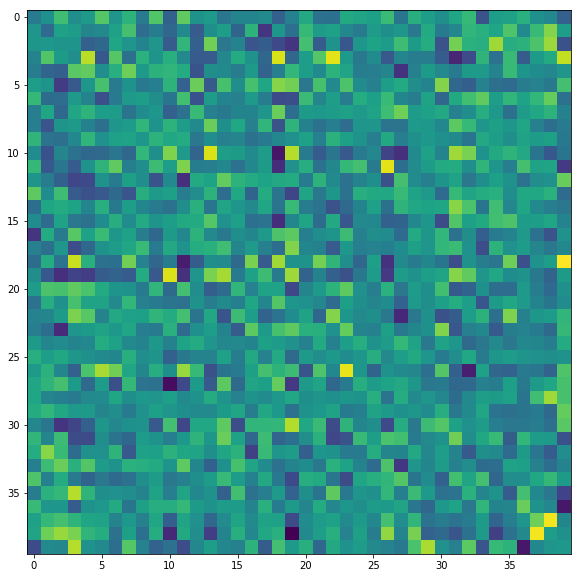

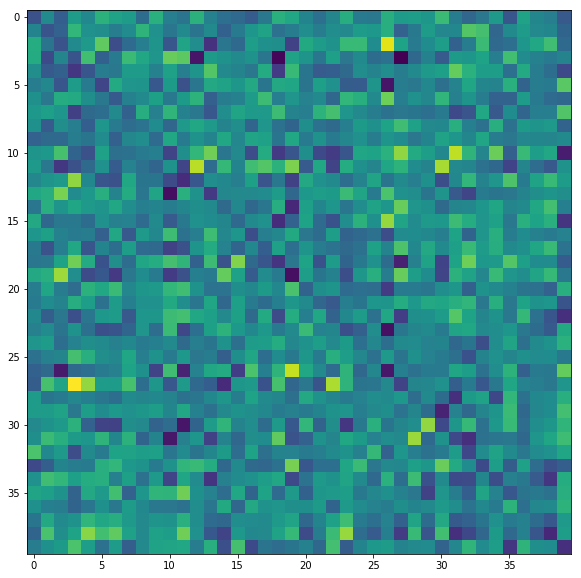

In [16]:
plt.figure(figsize = (10,10))
plt.imshow(np.real(GF_ret(0, 0.5*np.ones([2*H_shape[0]*H_shape[1]], dtype = 'complex128'))));plt.show()
plt.figure(figsize = (10,10))
plt.imshow(np.imag(GF_ret(0, 0.5*np.ones([2*H_shape[0]*H_shape[1]], dtype = 'complex128'))));plt.show()

#### Occupations over a range of voltages

The occupations $\langle \hat{d}_{i\sigma}\hat{d}^\dagger_{i'\sigma'} \rangle$ are obtained over a voltage-range given by V_arr. The array e_arr contains the energies over which is integrated to obtain the occupations from the lesser Green's functions in a self-consistent loops.

In [244]:
V_arr = np.linspace(-1,1,10)
e_arr = np.linspace(-10,10,20000)
mu0 = 0; beta = 2.5
Occ_store = Occ_sweep_V(mu0, V_arr, e_arr, n_it0 = 20, n_it = 20, beta = beta)

[0.39057894-1.14856220e-19j 0.42910745+3.29521598e-19j
 0.38732336+1.28468728e-19j 0.39921916+3.69316027e-19j
 0.37607666+2.70041856e-19j]
[0.39871025-8.85668361e-20j 0.44408582+2.81865382e-19j
 0.39902568-2.73302351e-20j 0.4157198 +3.29095557e-19j
 0.39384577+2.38957871e-19j]
[0.39697958-9.71693672e-20j 0.44313767-1.39290092e-19j
 0.39705874+9.20219454e-20j 0.41398694+4.56918659e-20j
 0.3911991 -1.19981698e-19j]
[0.39708534-4.15264861e-19j 0.44337103+1.12325399e-19j
 0.39725137-6.52375462e-20j 0.41428515-2.97928964e-20j
 0.3915943 +9.36341202e-20j]
[0.39705819+4.07415198e-19j 0.44335988+1.53928510e-19j
 0.39721677-5.71264103e-20j 0.41425482+8.12694895e-20j
 0.39153561-9.54058078e-21j]
[0.39705944+4.44616514e-19j 0.44336347+2.40269870e-20j
 0.39721992-2.21844125e-19j 0.41426039-5.17105696e-19j
 0.39154481+1.36779964e-19j]
[0.39705902-1.80740526e-19j 0.44336339-2.07332436e-19j
 0.3972193 +2.69964806e-19j 0.41425983+2.74135726e-20j
 0.39154346+2.46541404e-19j]
[0.39705902+5.00742452e-19j

[0.41473321+2.63755925e-20j 0.43979917+3.64442956e-19j
 0.41644223-9.84871228e-20j 0.4241747 +1.38218889e-19j
 0.41616003-4.16637006e-19j]
[0.42322762-1.07454089e-19j 0.4384406 +2.43274579e-19j
 0.42573362-2.74972010e-19j 0.42959651+4.03413910e-19j
 0.42908972-2.55481793e-19j]
[0.42354077-3.28289276e-19j 0.43717779+1.28385508e-19j
 0.42521278-1.30039257e-19j 0.42828257-2.26199052e-20j
 0.42741741-1.59419821e-19j]
[0.42369694+1.26161196e-19j 0.43709962-1.88864252e-20j
 0.42537424+2.38482971e-19j 0.42832987+3.96902667e-19j
 0.4276845 -3.20176810e-19j]
[0.4237097 +2.44000518e-19j 0.43707546+1.76554767e-20j
 0.42537187-3.99265000e-19j 0.42830726+2.60118008e-19j
 0.42764969-1.71643821e-19j]
[0.42371269+1.13802288e-19j 0.4370729 +2.86442613e-19j
 0.42537471+1.34855038e-20j 0.42830684+7.45731392e-19j
 0.42765536-7.90221074e-20j]
[0.42371309-3.70420769e-19j 0.43707242-2.63109626e-19j
 0.42537484-2.35832717e-19j 0.42830645-6.52435300e-19j
 0.42765462+8.30239286e-20j]
[0.42371314-2.61871999e-19j

[0.44180616+5.89704748e-19j 0.43109519+3.61458389e-20j
 0.44279608-7.56115018e-19j 0.43630552-4.13335541e-19j
 0.44903008-4.21364861e-19j]
[0.44180616-1.25864668e-21j 0.43109519-1.40722795e-19j
 0.44279608+1.96933330e-21j 0.43630552+3.01287435e-19j
 0.44903008-1.70748489e-19j]
[0.45040316+3.94822837e-19j 0.42992008+6.57873734e-20j
 0.45205018+7.18569769e-19j 0.44206037+1.34993040e-19j
 0.4601141 -1.20003621e-19j]
[0.45068258-3.91292594e-19j 0.42858981+6.12111540e-19j
 0.45151249-4.92215388e-19j 0.44072365+5.07187935e-19j
 0.45892842+2.76607951e-19j]
[0.45085999+3.03285894e-19j 0.42852781-8.88673067e-20j
 0.45166792-2.24444624e-19j 0.44077162-4.66510974e-20j
 0.45914366+2.91604855e-19j]
[0.4508707 +1.15690440e-18j 0.4285005 -4.70270884e-19j
 0.45166617+2.73654538e-19j 0.44074905-1.62921620e-19j
 0.45912445-2.46082199e-19j]
[0.45087444-3.43582943e-19j 0.42849837+2.39318661e-19j
 0.45166875-1.07699299e-19j 0.44074857-3.07957211e-19j
 0.45912866+1.67406423e-19j]
[0.45087477+8.90399072e-20j

[0.46916502-2.13439473e-19j 0.4257834 -1.09291040e-19j
 0.47054182+5.63129413e-20j 0.45171805-2.27000326e-19j
 0.47916925+1.01089010e-19j]
[0.46916502-3.58027032e-20j 0.4257834 -5.56297500e-20j
 0.47054182+3.18439473e-19j 0.45171805-2.36582939e-19j
 0.47916925+3.86803078e-19j]
[0.46916502-3.89921117e-19j 0.4257834 +8.55211781e-20j
 0.47054182+1.95409159e-19j 0.45171805-2.62860290e-19j
 0.47916925+8.82979968e-22j]
[0.47842431+7.76813187e-20j 0.42746436-4.47089329e-20j
 0.48147225-1.06981095e-19j 0.46002406-1.03629473e-19j
 0.49070333-6.62753927e-20j]
[0.47838374-5.73155840e-19j 0.42628299+2.59019221e-19j
 0.48062306-1.45761756e-19j 0.45852323-1.42538703e-19j
 0.48944632-1.15503767e-20j]
[0.4785308 +2.32387748e-19j 0.42627399+5.28812132e-19j
 0.48077807+5.88752119e-19j 0.45861186-8.41754104e-19j
 0.48965591+1.14964446e-20j]
[0.47853527+2.01389726e-19j 0.42625704-2.45578548e-19j
 0.48077072+7.48602374e-19j 0.45859029+2.25088286e-19j
 0.48963663+1.94209765e-19j]
[0.47853745-1.86667163e-19j

In [134]:
Occ_store.shape

(10, 5, 4, 2, 5, 4, 2)

#### Obtaining the current and transmissions

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


-1.1042415683336992
-0.8722862823686626
-0.6303649517620766
-0.381147723321958
-0.1275258134679227
0.12749770988319323
0.38090740668101447
0.6297639454323802
0.8712889268165813
1.1029535401627895


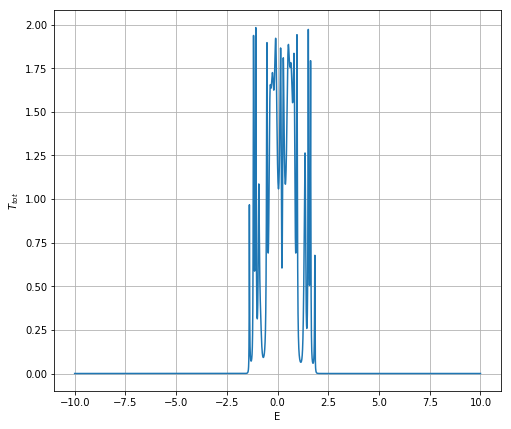

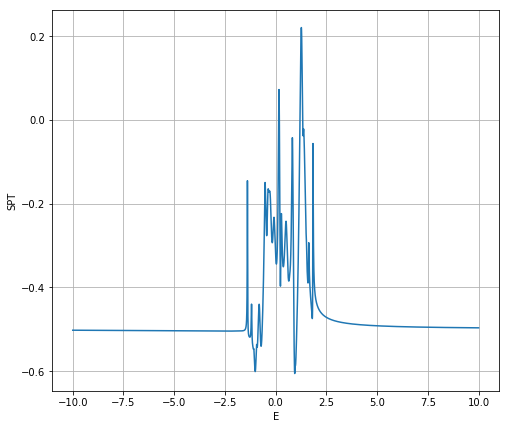

In [245]:

#e_arr = np.linspace(-5,5,5000)
I_store = np.zeros([len(V_arr)], dtype = 'complex128')

for j in range(0,len(V_arr)):
    muL_j = mu0 + V_arr[j]/2; muR_j = mu0 - V_arr[j]/2
    FD_diff_arr = FD_dist(e_arr, muL_j, beta) - FD_dist(e_arr, muR_j, beta)
    
    
    T_store = np.zeros([len(e_arr)])
    T_pol_store = np.zeros([4,len(e_arr)])

    Occ_res_j = np.reshape(Occ_store[j], [2*H_shape[0]*H_shape[1], 2*H_shape[0]*H_shape[1]])
    n_arr_vec_j = Occ_res_j[np.arange(0,2*H_shape[0]*H_shape[1]), np.arange(0,2*H_shape[0]*H_shape[1])]

    for i in range(0,len(e_arr)):
        G_ret_res = GF_ret(e_arr[i], n_arr_vec_j)

       # G_ret_res = np.linalg.inv((e_arr[i] + 0.0000000j)*np.eye(Hres.shape[0], Hres.shape[1]) - Hres - Sigma_tot_res)
        G_adv_res = np.conj(np.transpose(G_ret_res))
        T_tot = np.trace(np.dot(Gamma_L_res, np.dot(G_ret_res, np.dot(Gamma_R_res, G_adv_res))))
        T_store[i] = T_tot

        Ti_down = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_down,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_down,G_adv_res))))))
        Ti_up = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_up,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_up,G_adv_res))))))
        Ti_du = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_up,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_down,G_adv_res))))))
        Ti_ud = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_down,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_up,G_adv_res))))))

        T_pol_store[:,i] = np.array([Ti_down, Ti_up, Ti_du, Ti_ud])

        #print(Ti_down + Ti_up + Ti_du + Ti_ud - T_tot)
        #print((-Ti_down + Ti_up + Ti_du - Ti_ud)/ T_tot)
    #I_store_j = np.abs(e_arr[1] - e_arr[0])*np.sum(T_store*FD_diff_arr)
    I_store_j = integrate_n_flipaxes(T_store*FD_diff_arr, 3, np.abs(e_arr[1] - e_arr[0]))
    I_store[j] = I_store_j
    print(I_store_j)
    
SPT_store = (T_pol_store[1] + T_pol_store[2] - T_pol_store[0] - T_pol_store[3])/T_store
plt.figure(figsize = (8,7))
plt.plot(e_arr, T_store)
plt.xlabel('E');plt.ylabel(r'$T_{tot}$')
plt.grid()
plt.show()
plt.figure(figsize = (8,7))
plt.plot(e_arr, SPT_store)
plt.xlabel('E');plt.ylabel('SPT')
plt.grid()
plt.show()


In [83]:
SPT_store2 = np.copy(SPT_store)
T_store2 = np.copy(T_store)

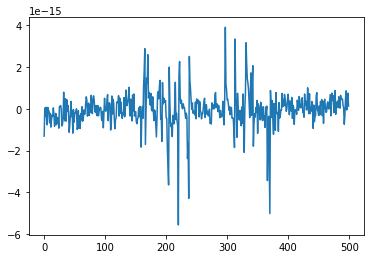

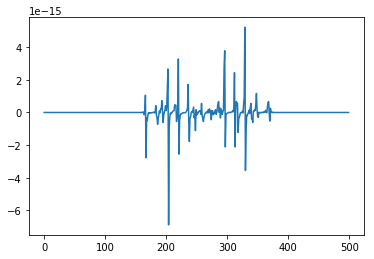

In [100]:
plt.plot(SPT_store2 + SPT_store);plt.show()
plt.plot(T_store2 - T_store);plt.show()

#### Comparing the currents
Here, the difference between two currents can be determined. This can be used to obtain the current-difference $\Delta I$ and Magnetoresistance $\Delta I/\Sigma I$, which are plotted below. 

In [241]:
I_store2 = np.copy(I_store)

C:\Programs\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


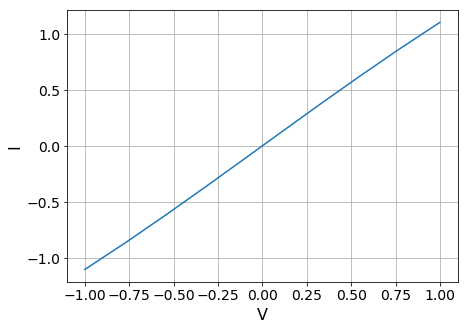

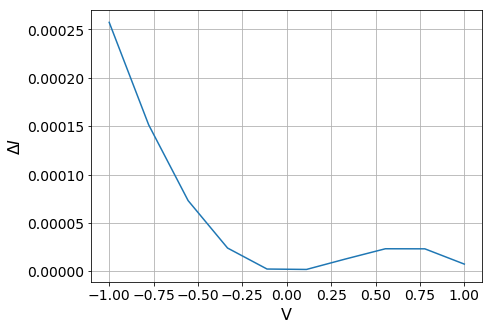

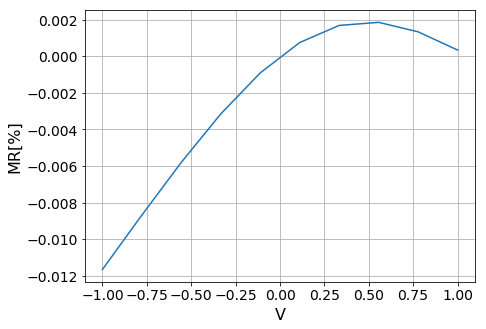

In [246]:
plt.figure(figsize = (7,5))
plt.plot(V_arr, I_store);
plt.xlabel('V', fontsize = 16);plt.ylabel('I', fontsize = 16)
plt.xticks(fontsize = 14);plt.yticks(fontsize = 14)
plt.grid();plt.show()

plt.figure(figsize = (7,5))
plt.plot(V_arr, I_store2 - I_store);
plt.xlabel('V', fontsize = 16);plt.ylabel(r'$\Delta I$', fontsize = 16)
plt.xticks(fontsize = 14);plt.yticks(fontsize = 14)
plt.grid();plt.show()

plt.figure(figsize = (7,5))
plt.plot(V_arr, 100*(I_store2 - I_store)/(I_store2 + I_store));
plt.xlabel('V', fontsize = 16);plt.ylabel('MR[%]', fontsize = 16)
plt.xticks(fontsize = 14);plt.yticks(fontsize = 14)
plt.grid();plt.show()

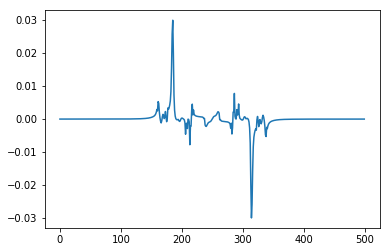

In [304]:
plt.plot((T_pol_store[1,:] + T_pol_store[2,:] - T_pol_store[0,:] - T_pol_store[3,:])/T_store)

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


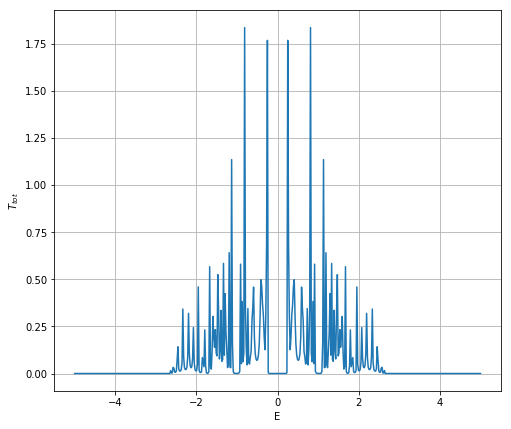

0


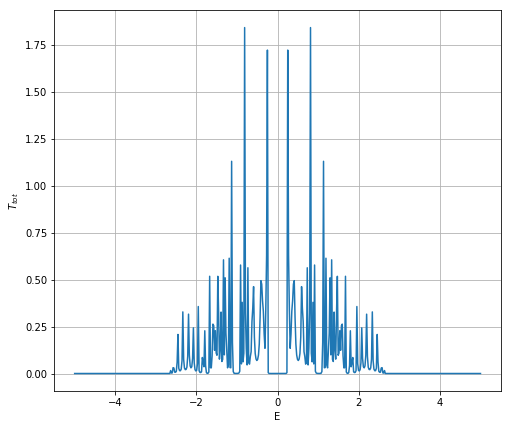

1


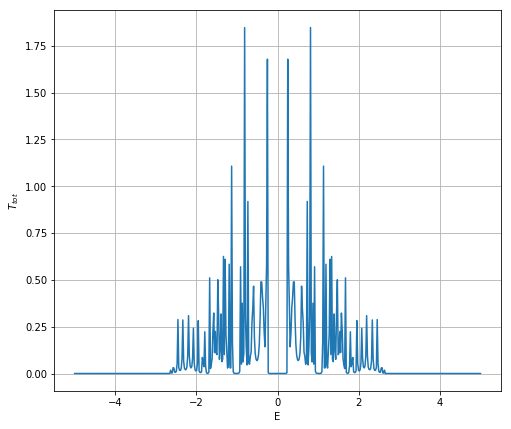

2


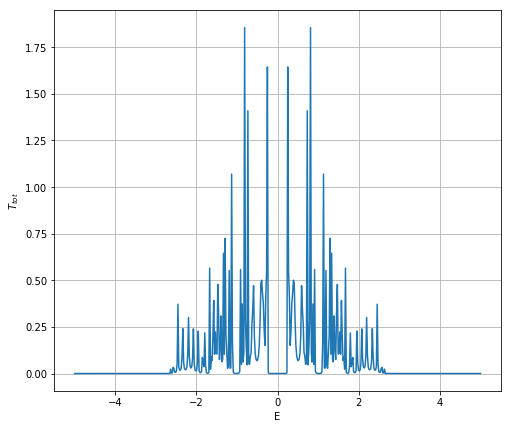

3


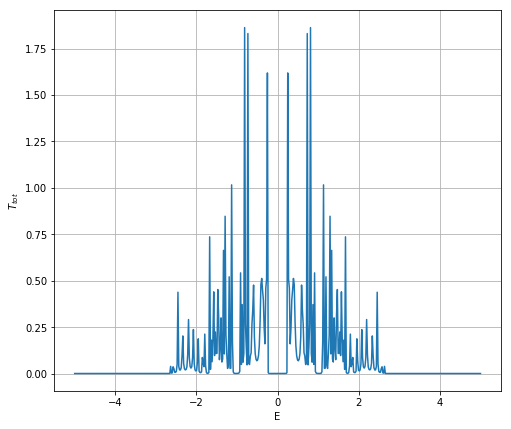

4


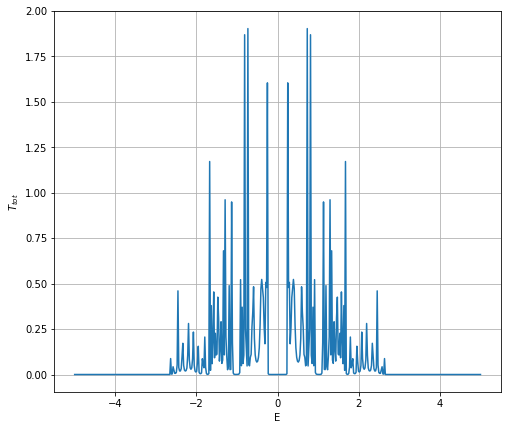

5


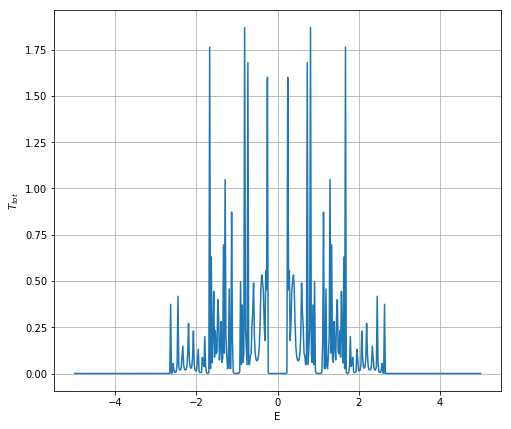

6


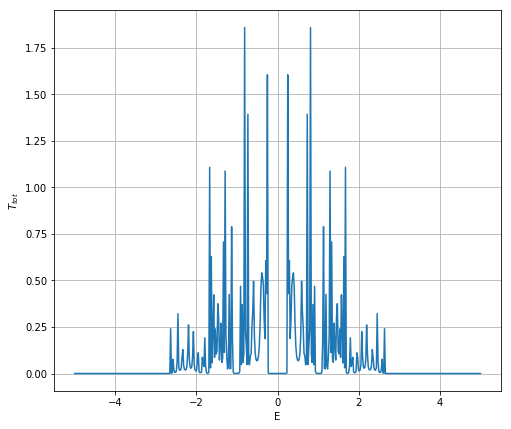

7


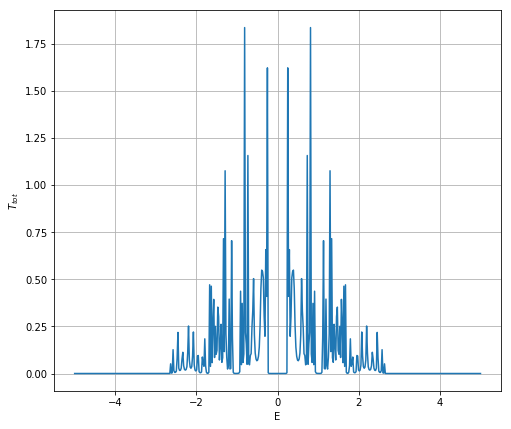

8


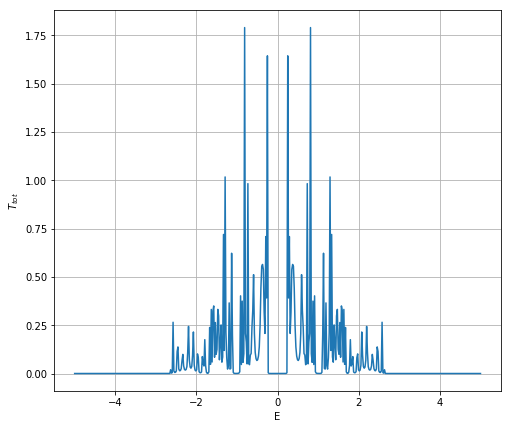

9


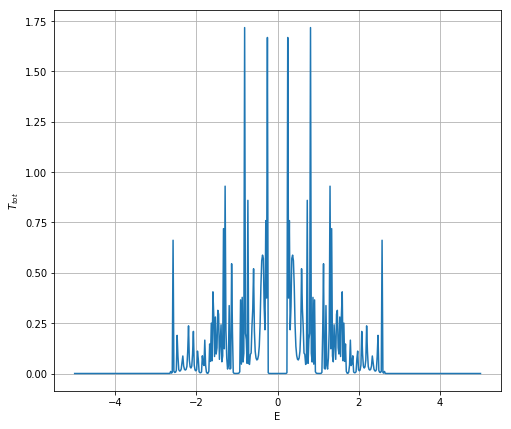

10


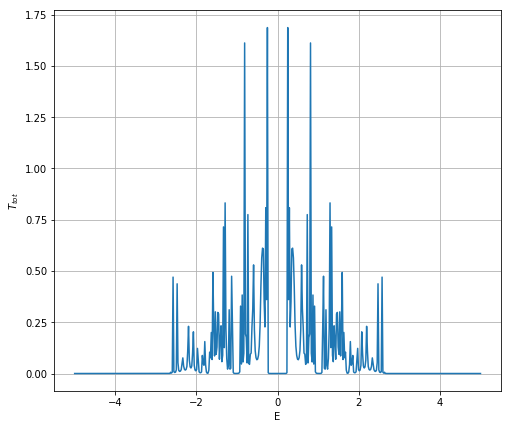

11


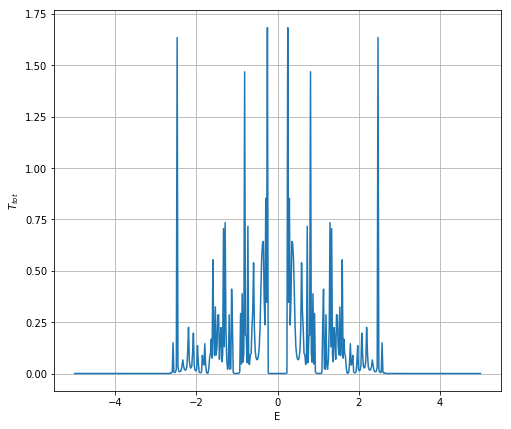

12


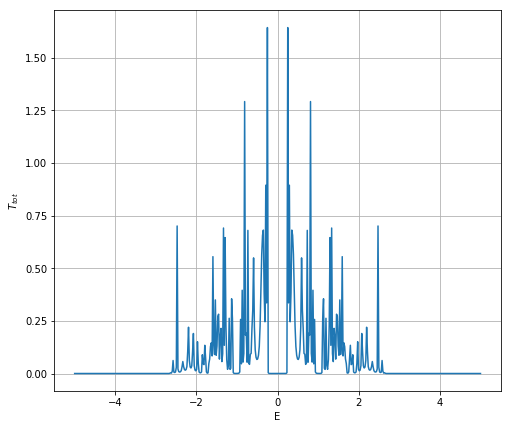

13


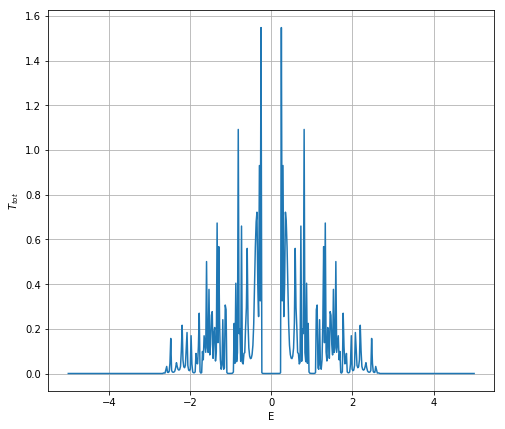

14


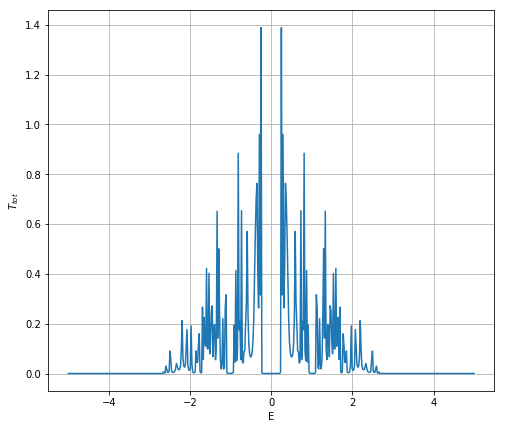

15


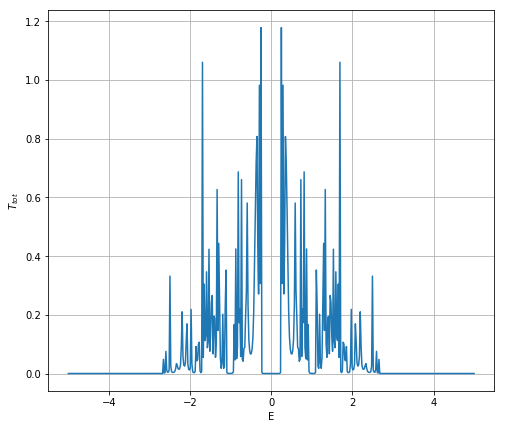

16


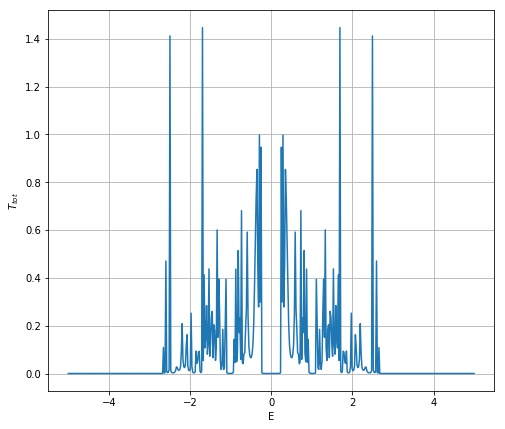

17


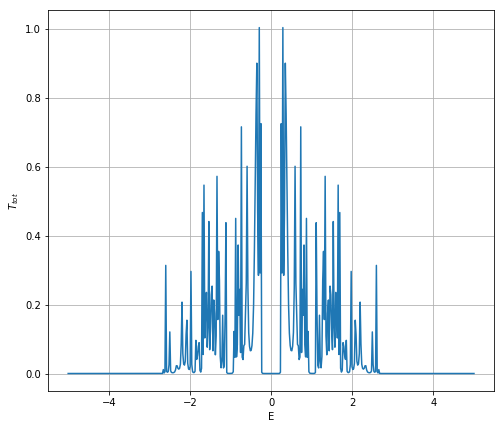

18


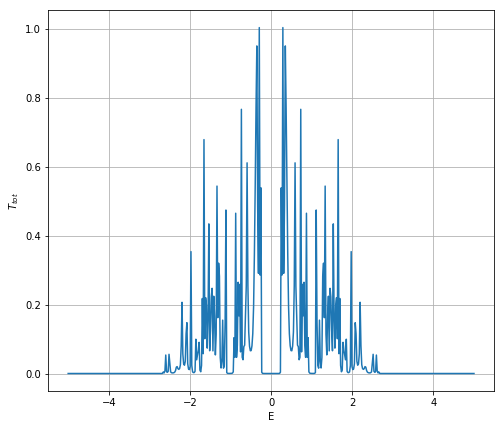

19


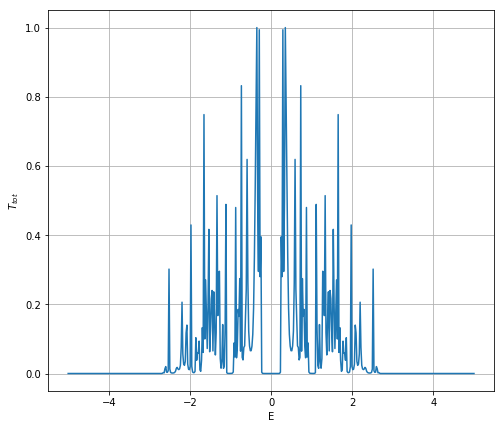

20


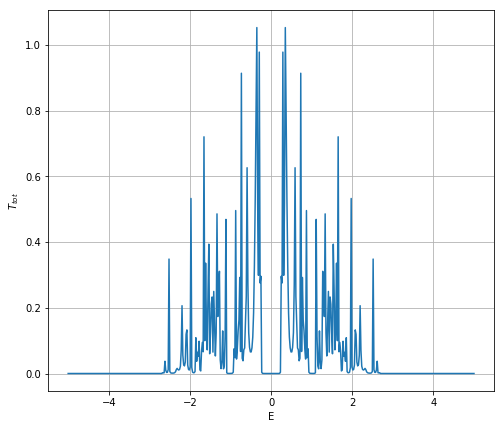

21


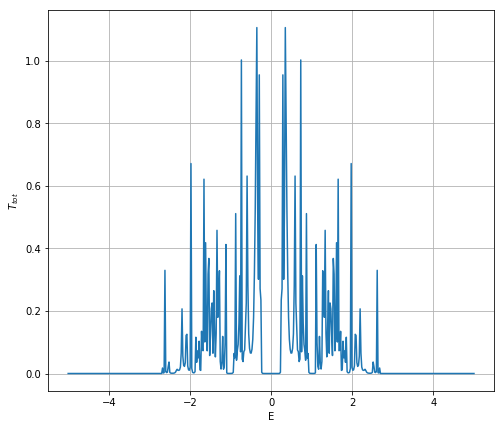

22


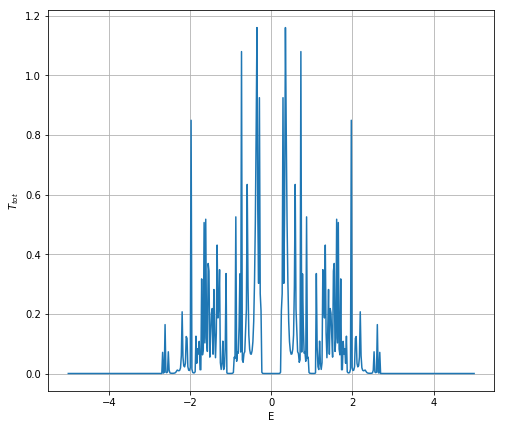

23


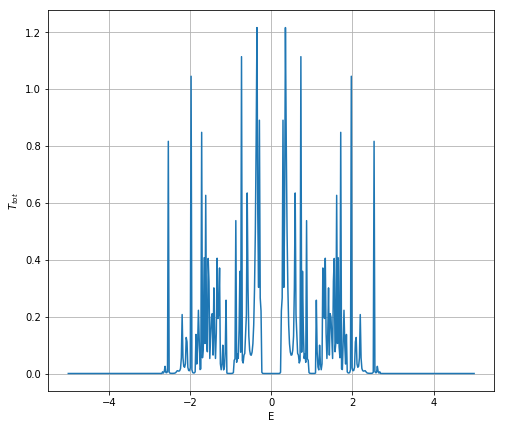

24


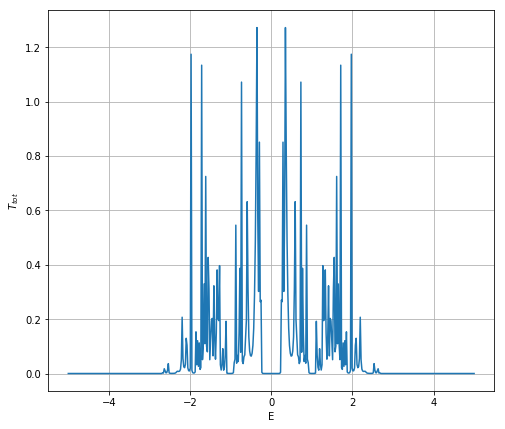

25


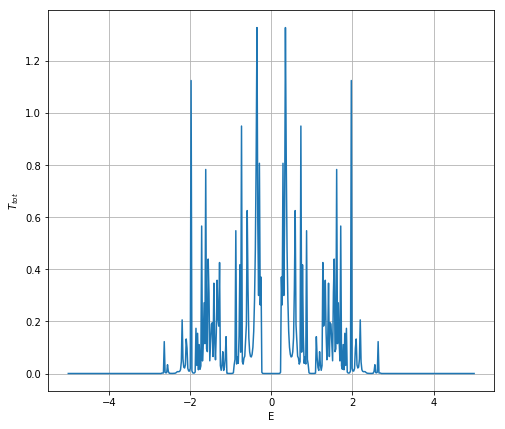

26


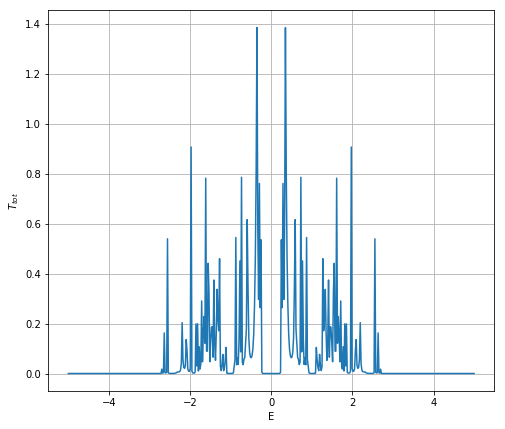

27


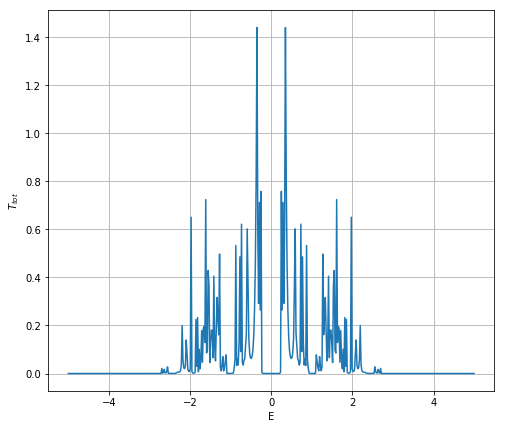

28


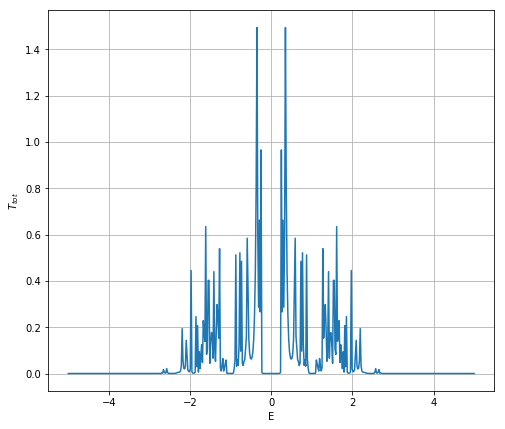

29


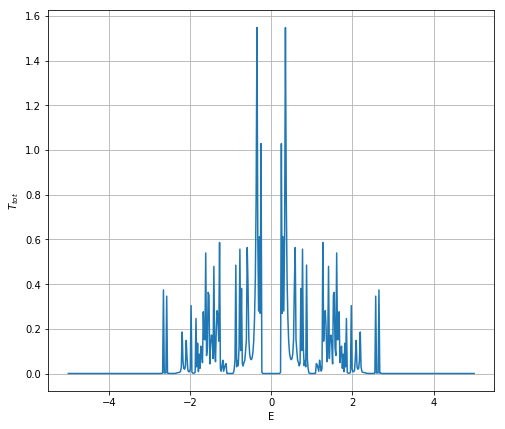

30


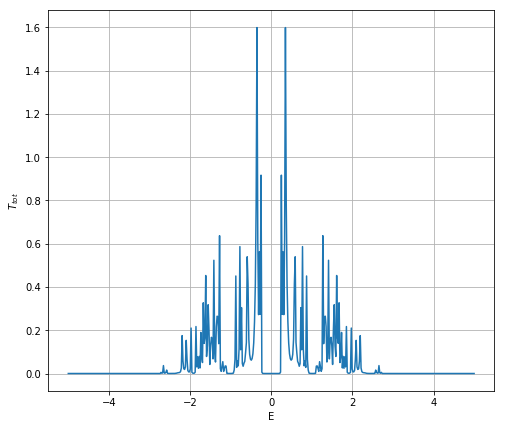

31


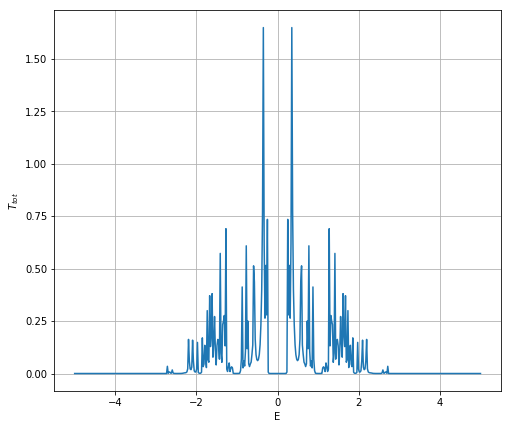

32


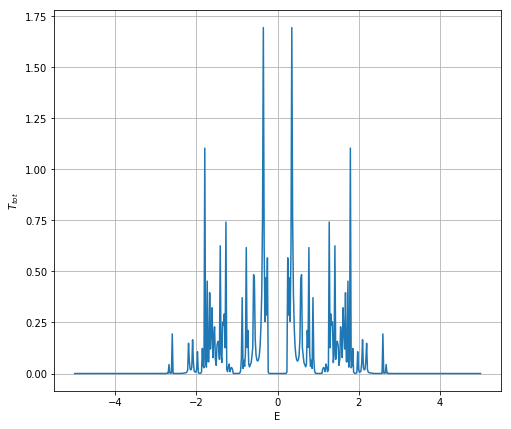

33


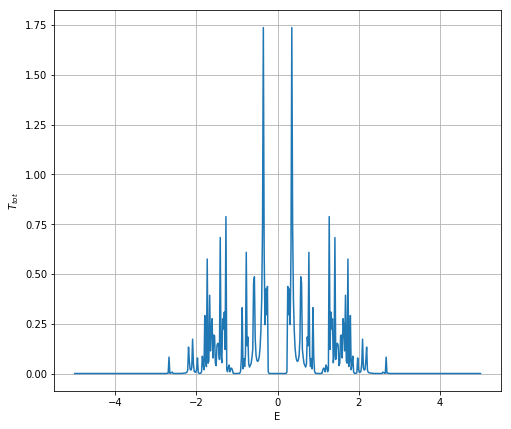

34


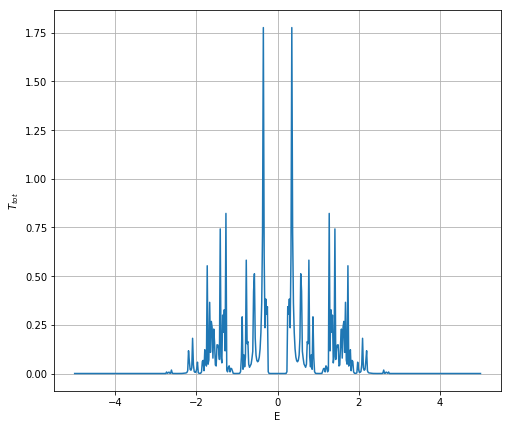

35


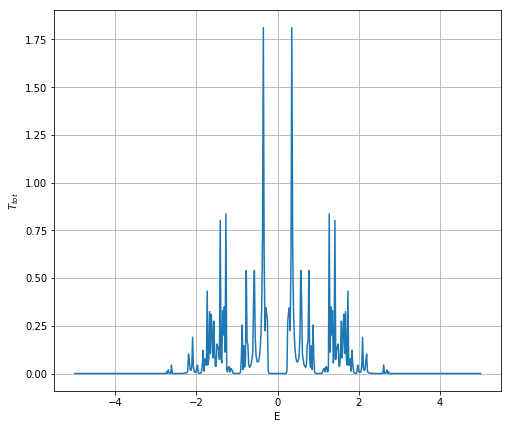

36


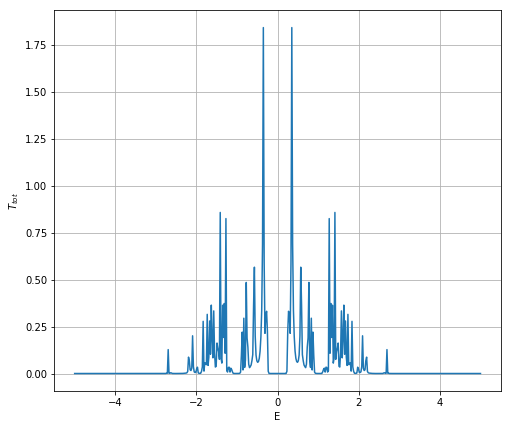

37


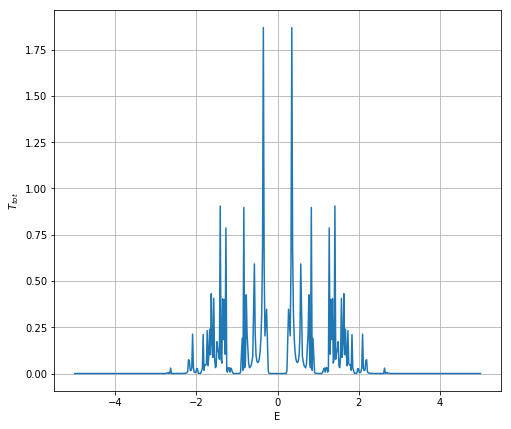

38


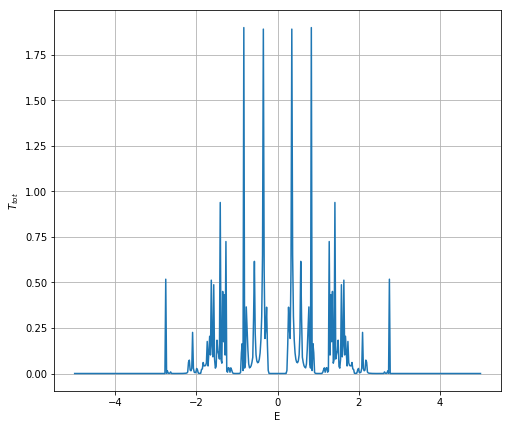

39


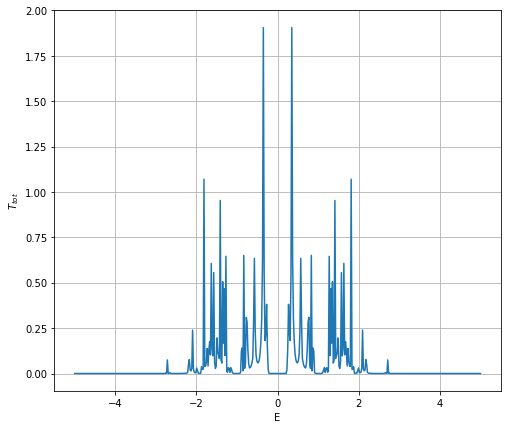

40


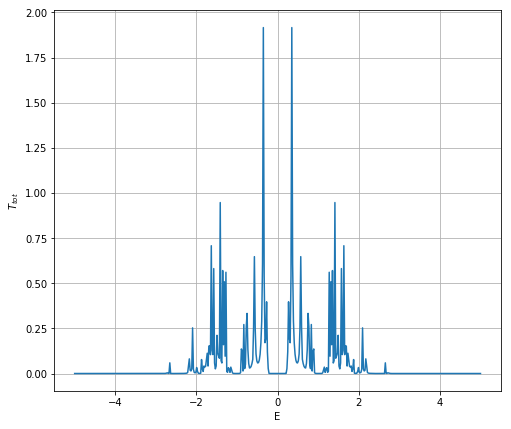

41


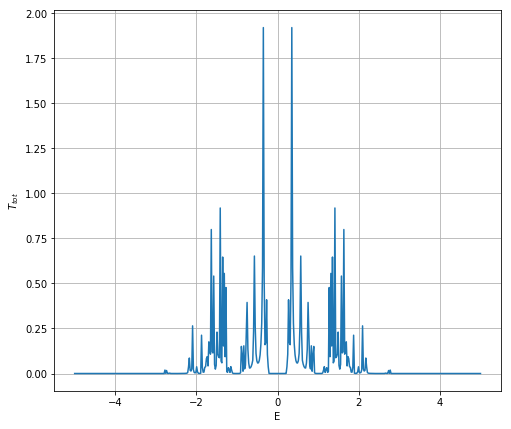

42


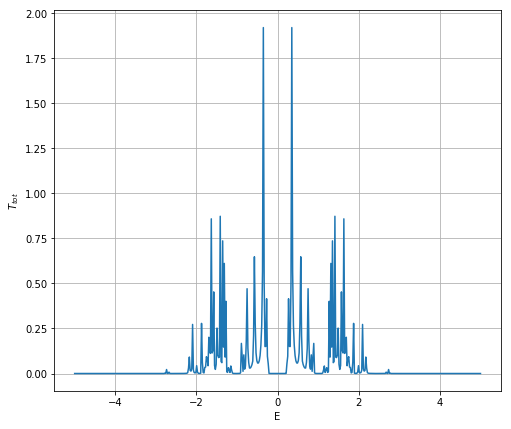

43


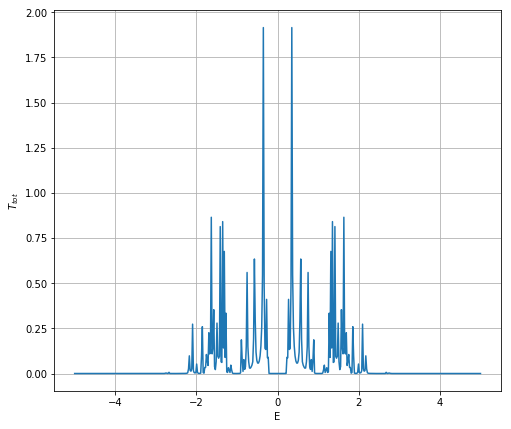

44


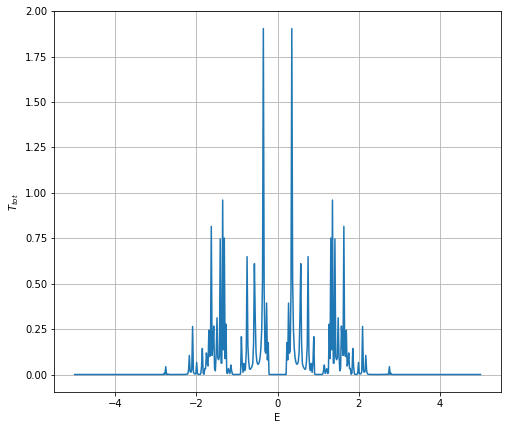

45


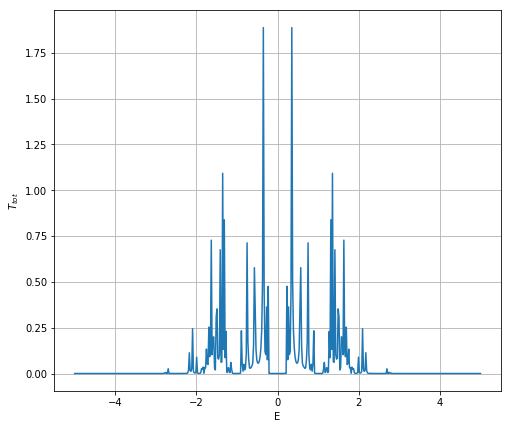

46


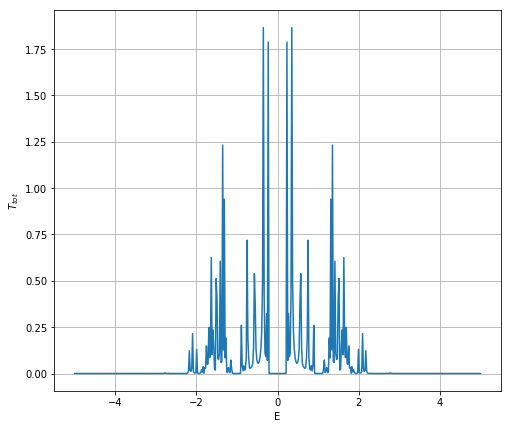

47


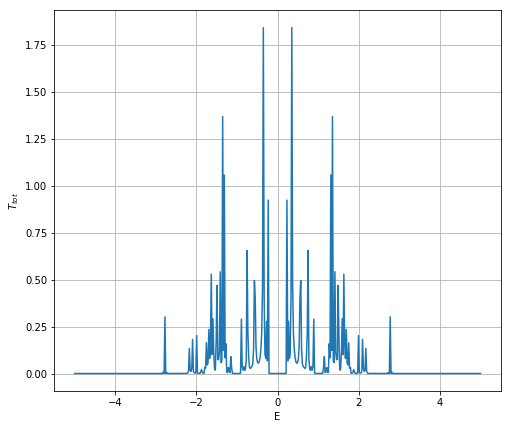

48


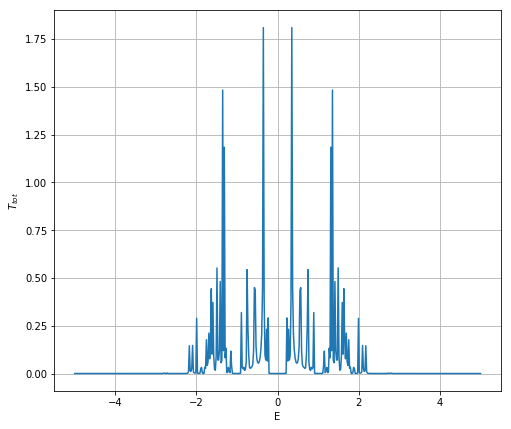

49


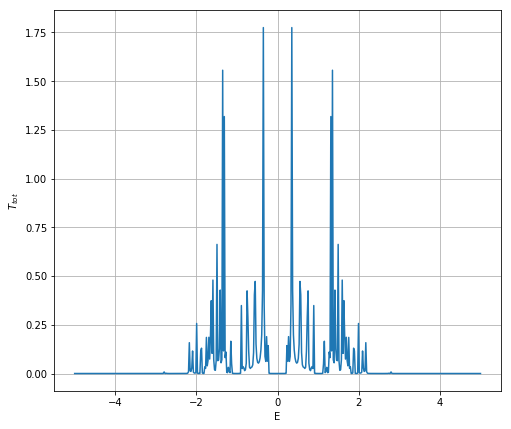

50


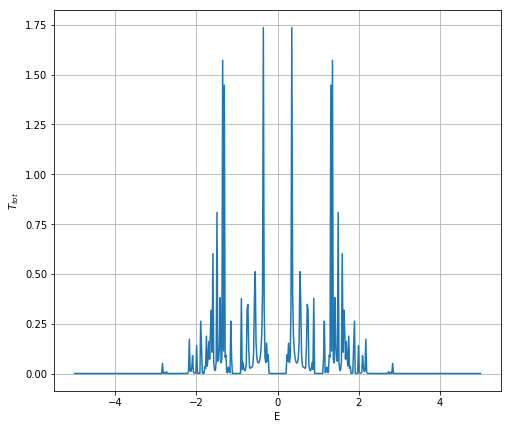

51


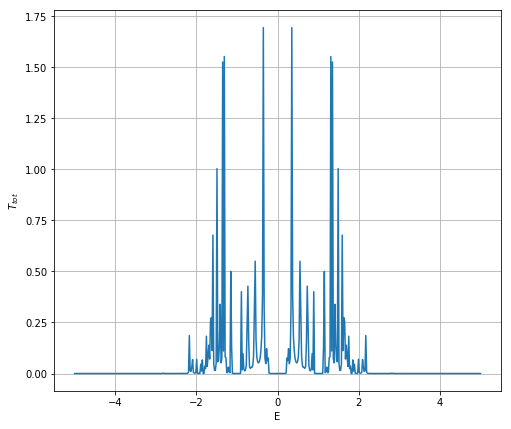

52


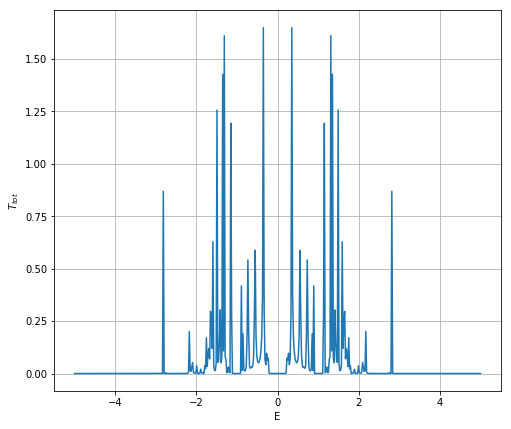

53


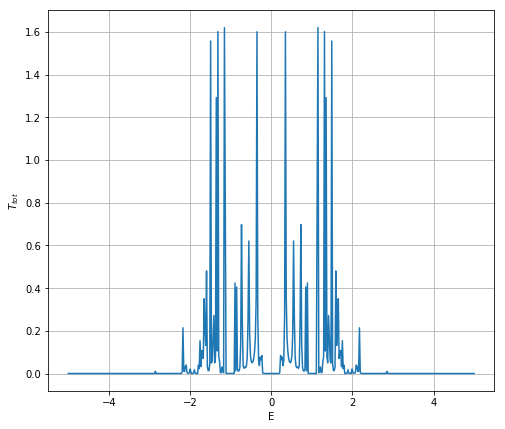

54


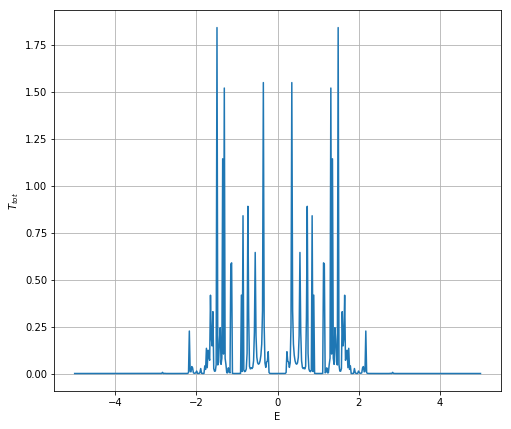

55


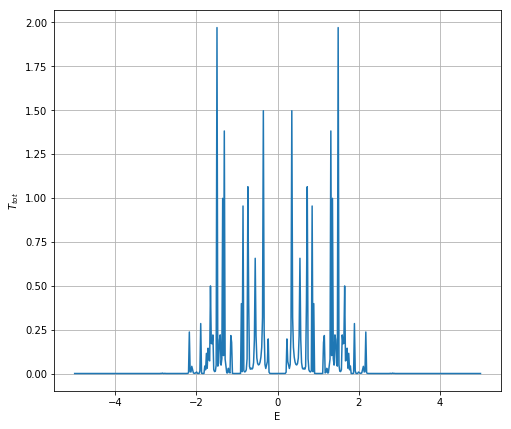

56


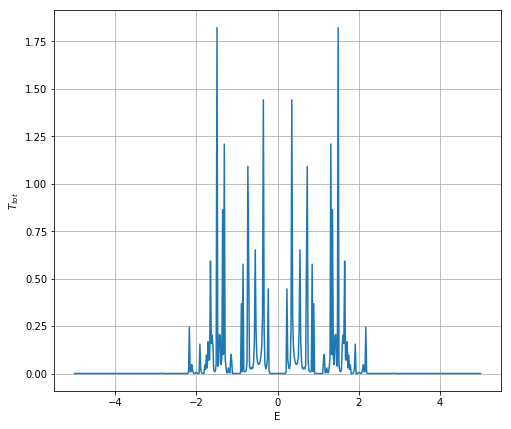

57


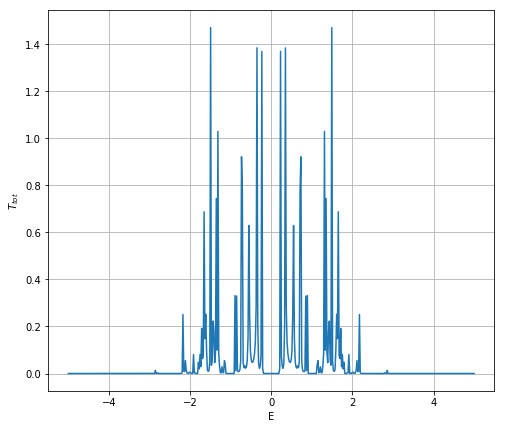

58


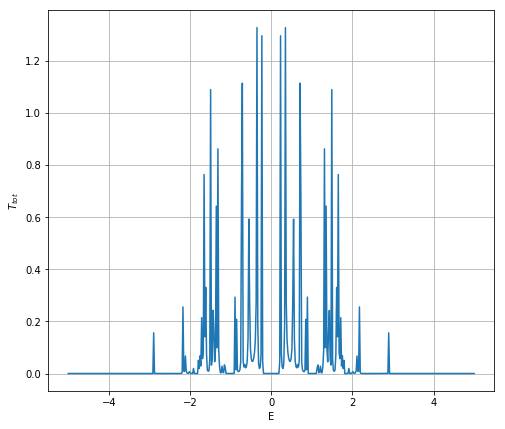

59


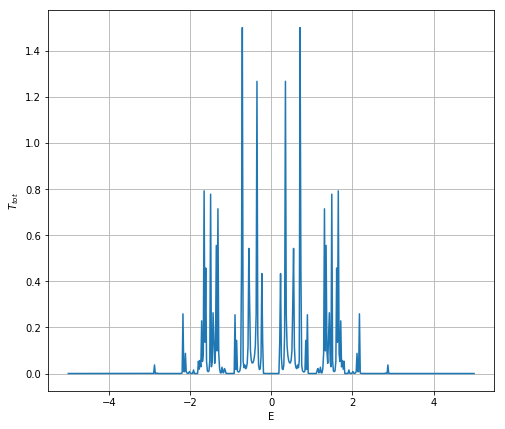

60


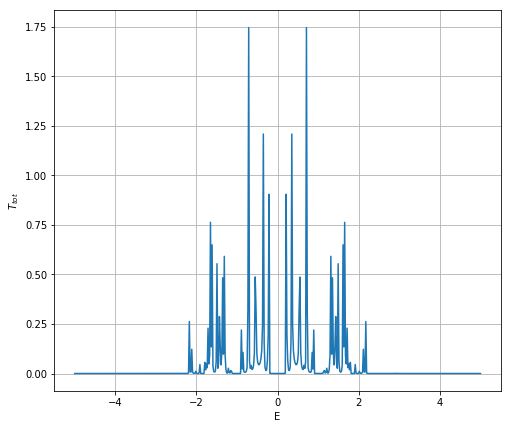

61


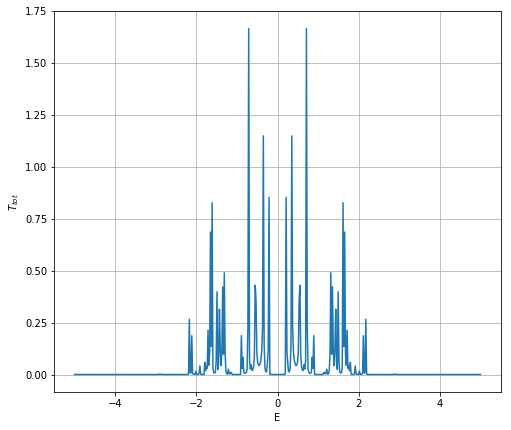

62


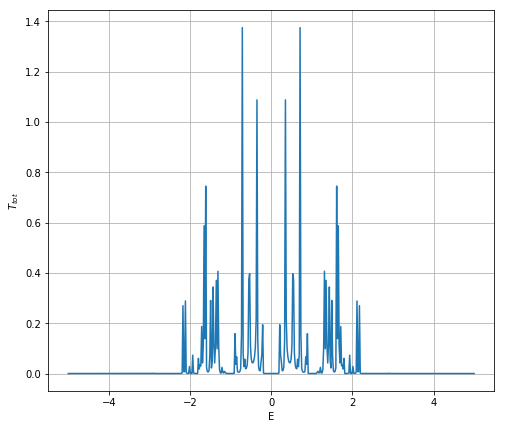

63


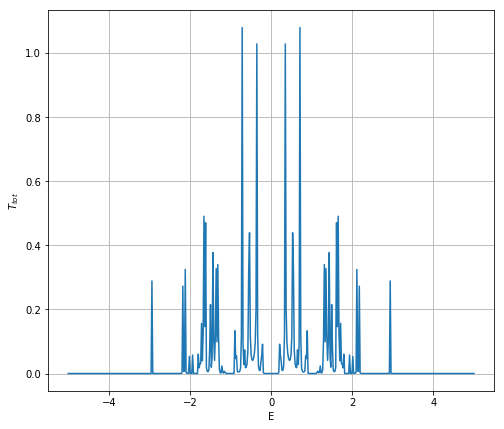

64


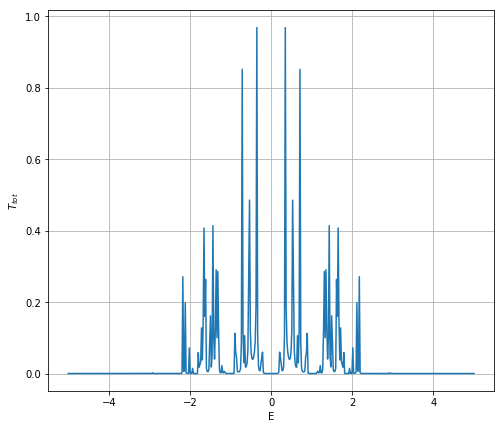

65


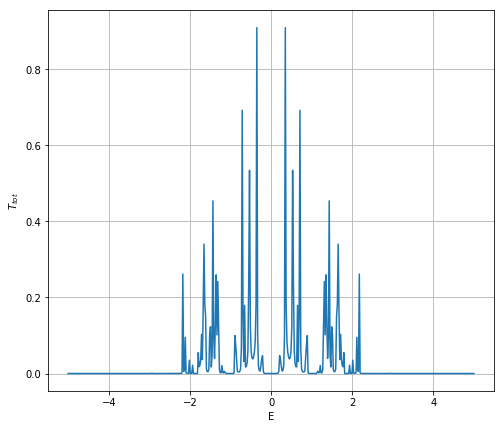

66


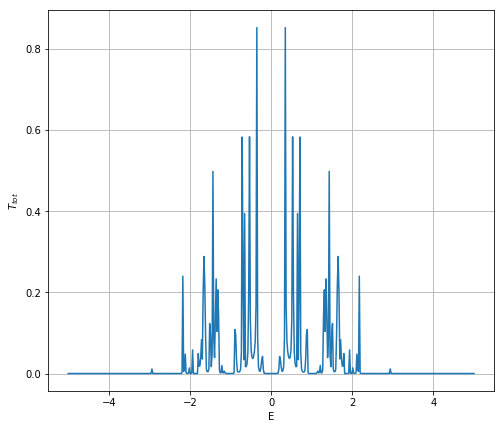

67


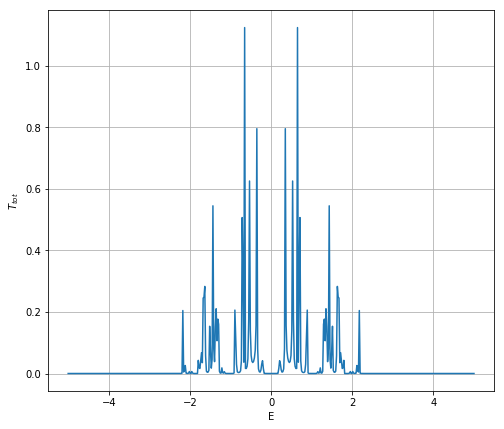

68


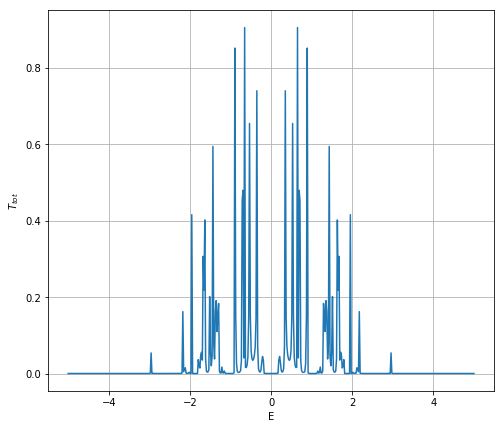

69


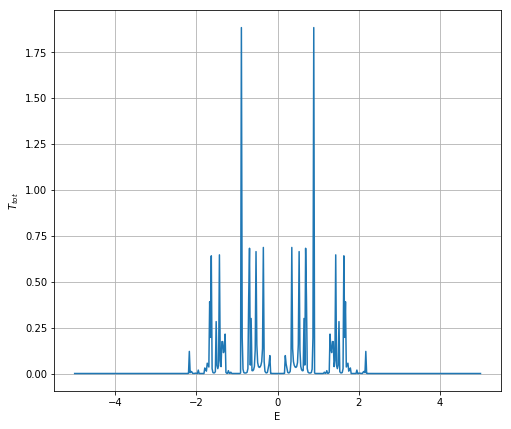

70


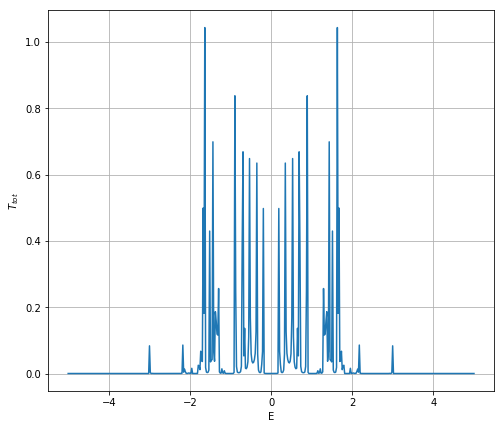

71


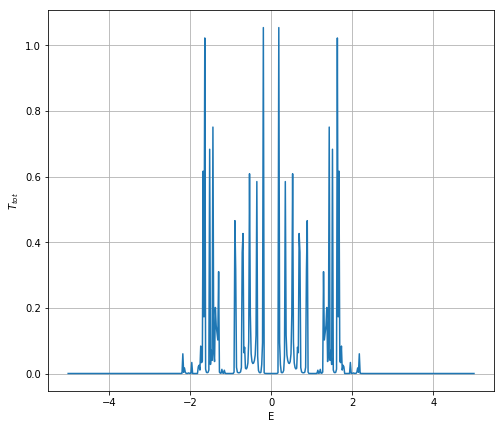

72


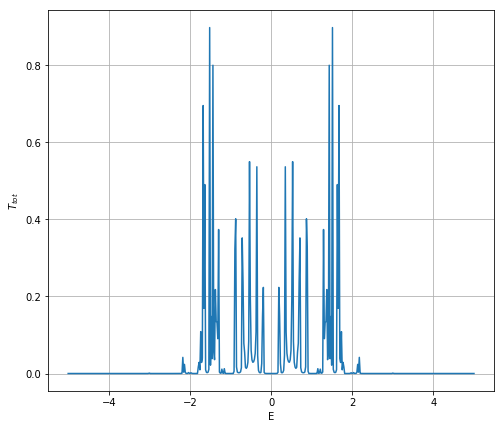

73


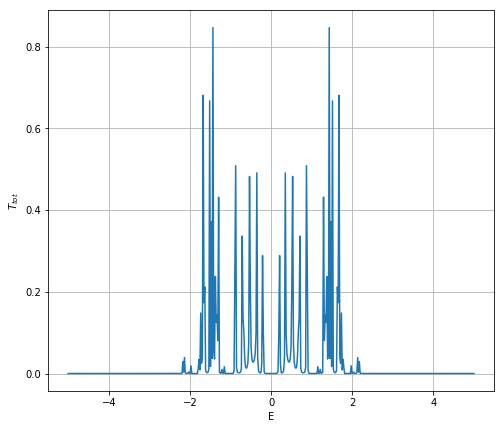

74


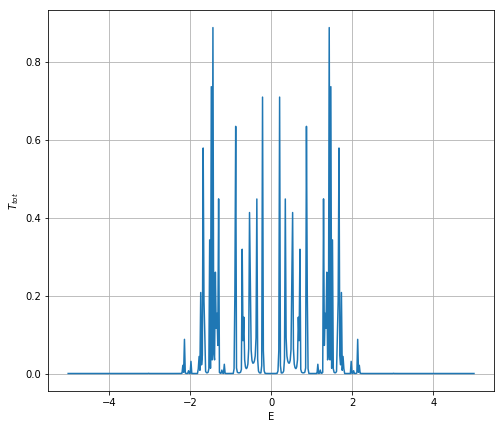

75


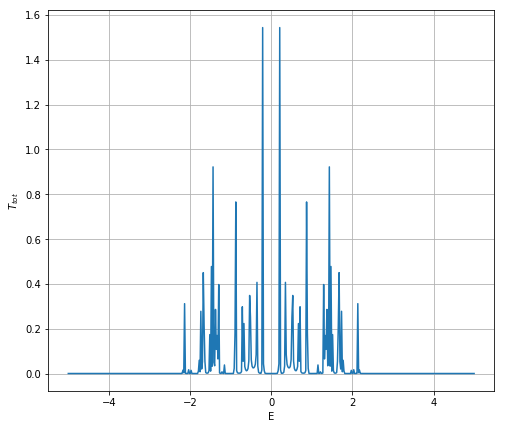

76


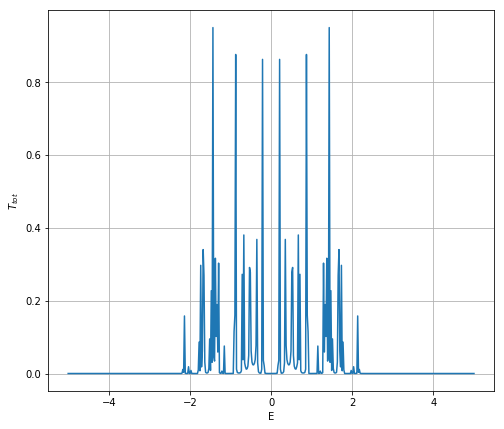

77


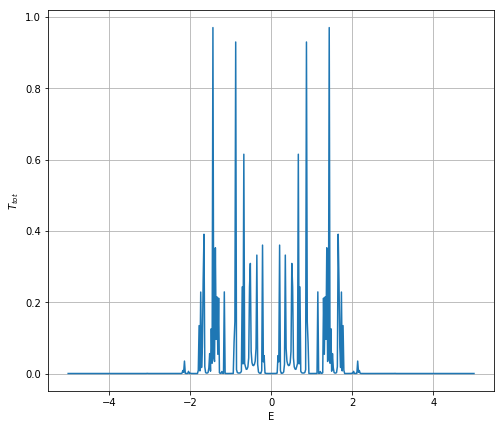

78


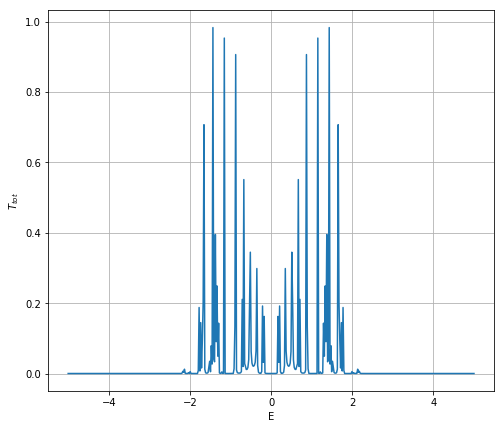

79


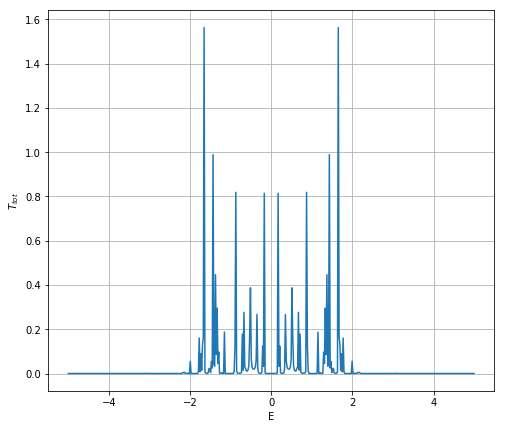

80


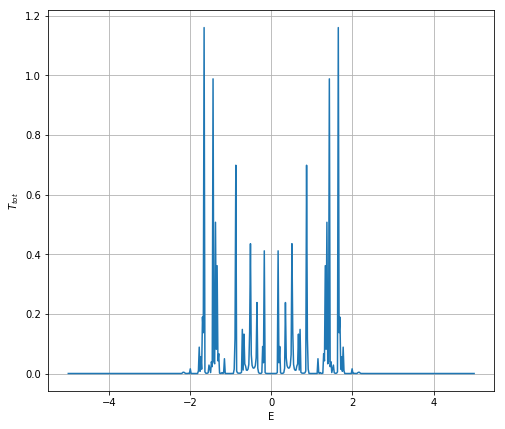

81


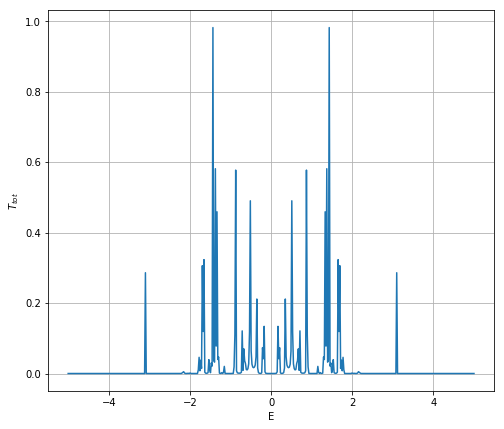

82


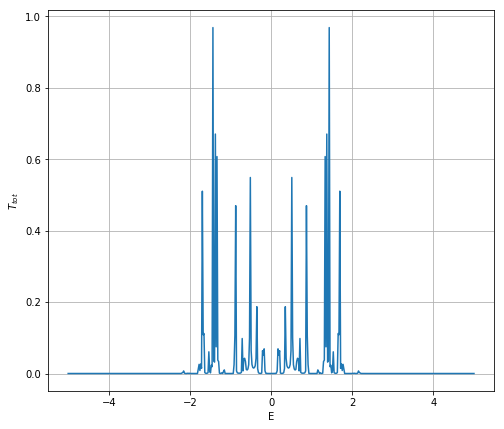

83


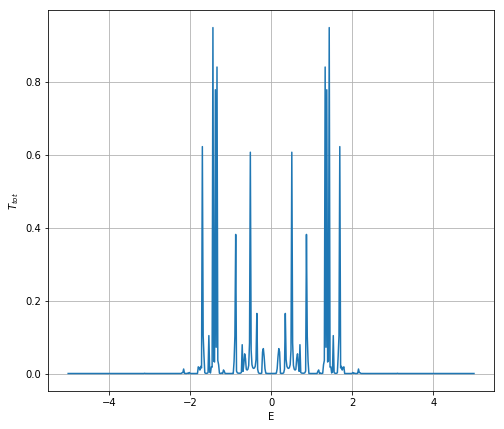

84


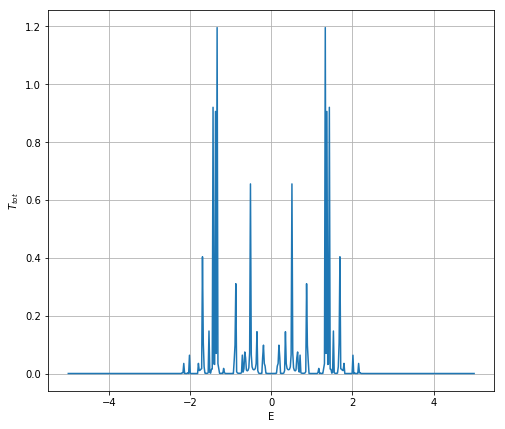

85


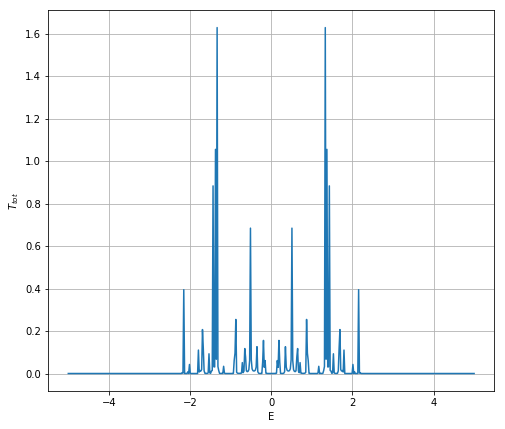

86


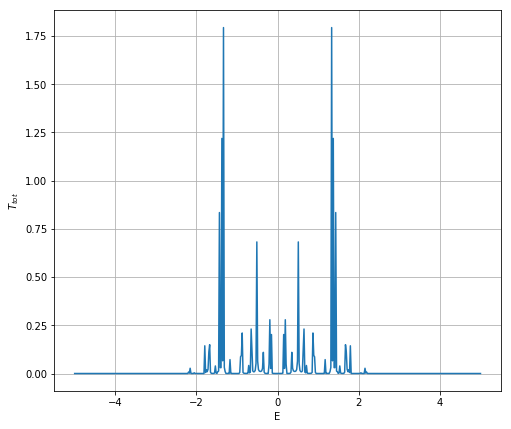

87


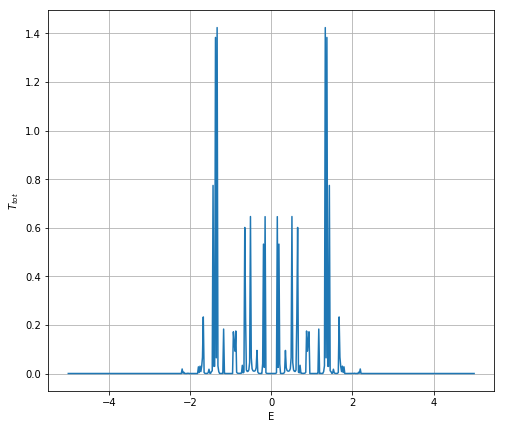

88


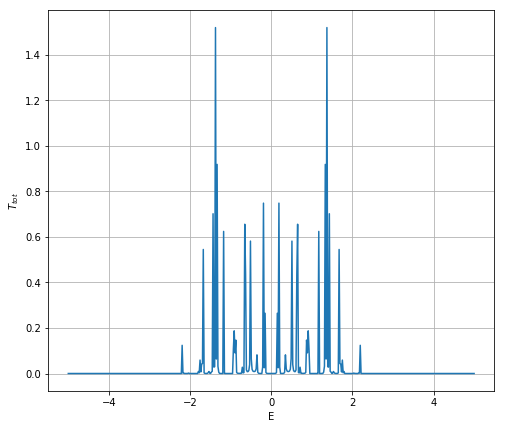

89


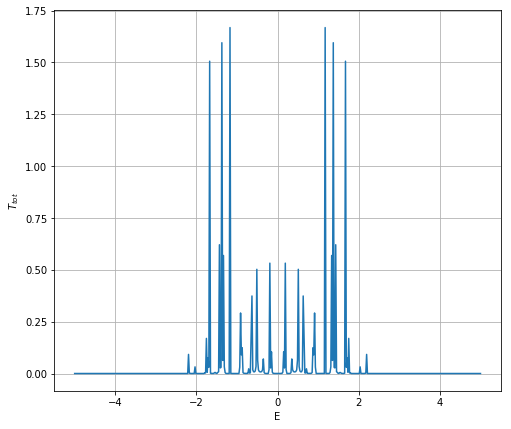

90


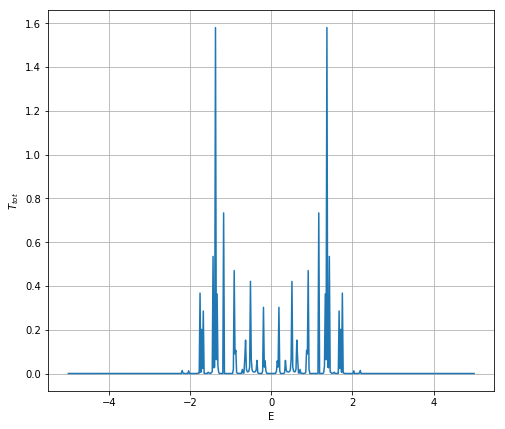

91


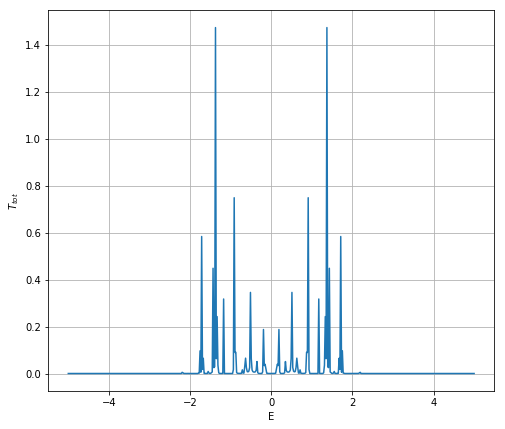

92


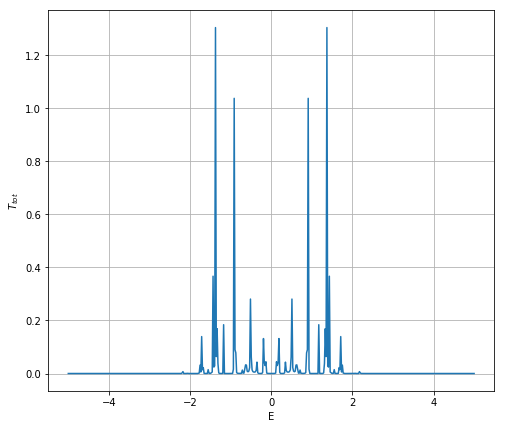

93


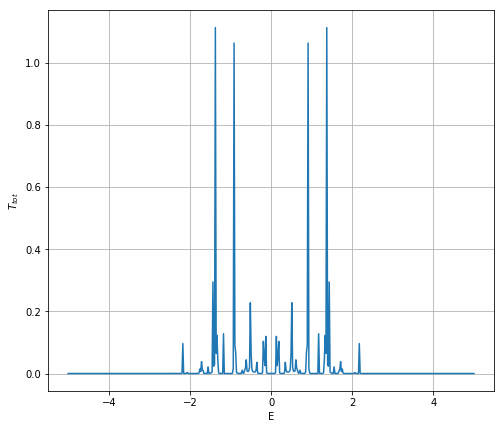

94


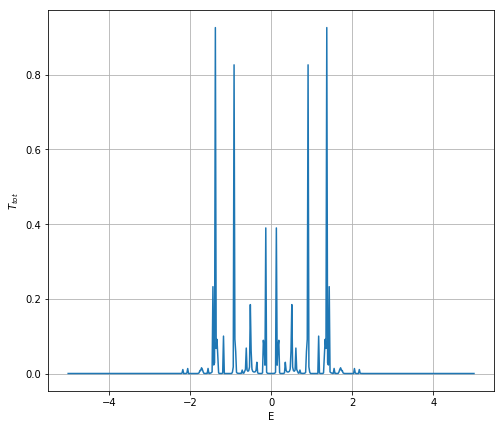

95


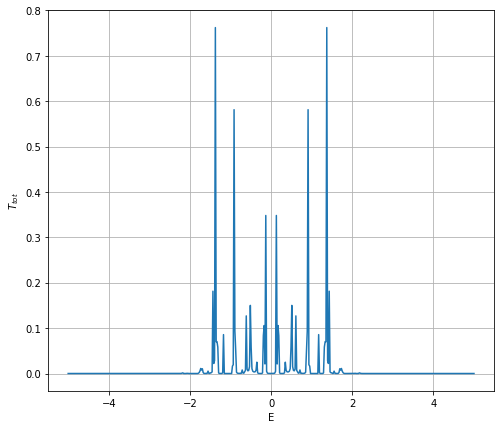

96


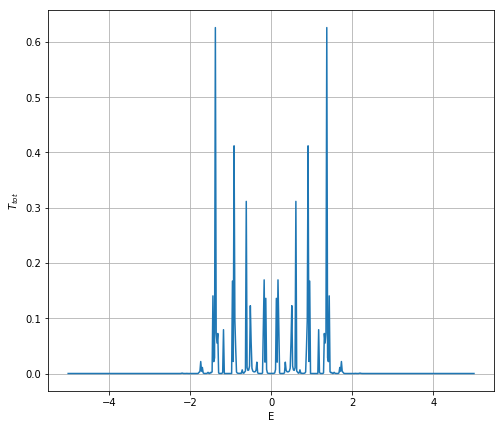

97


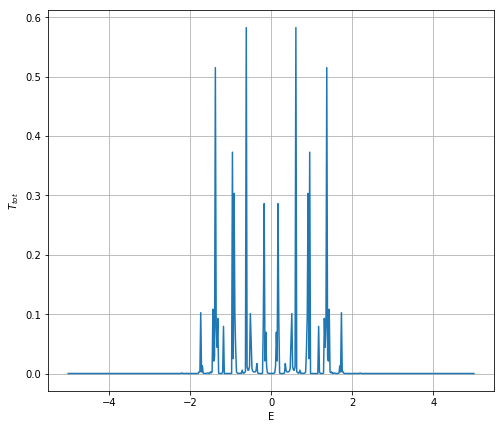

98


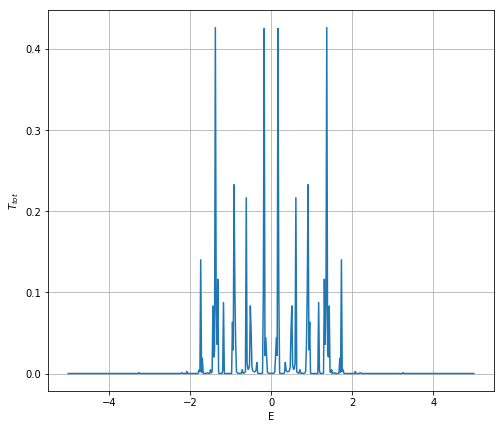

99


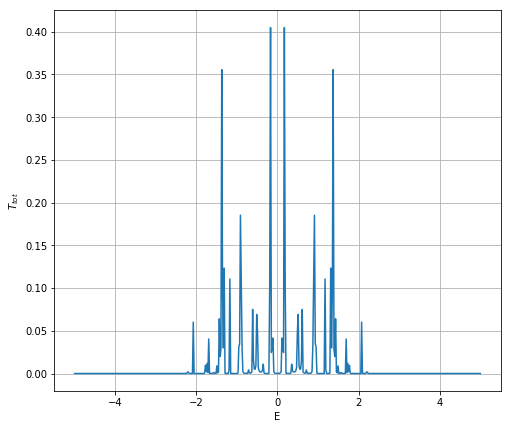

100


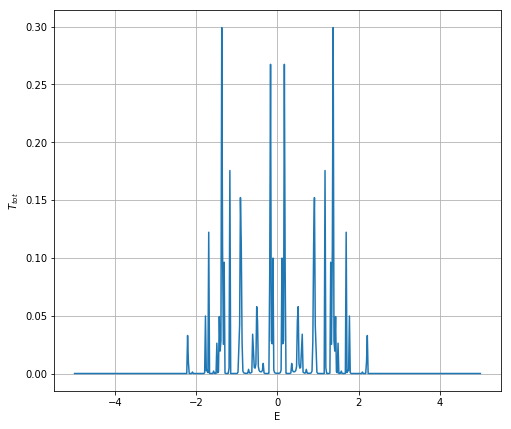

101


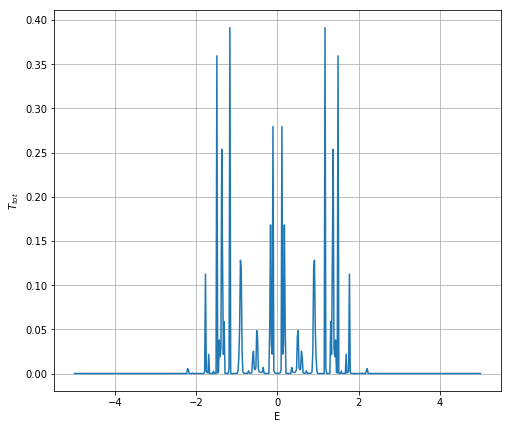

102


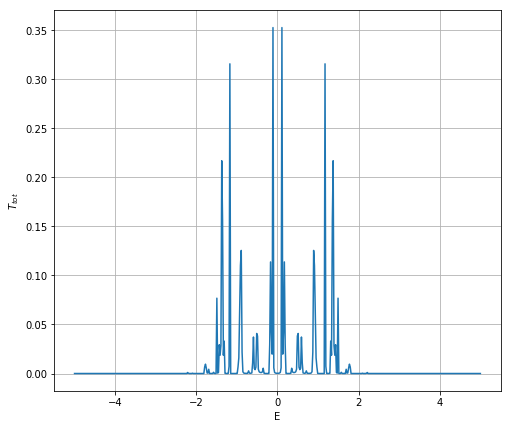

103


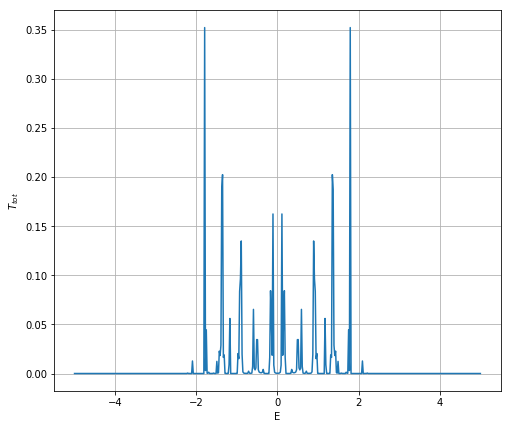

104


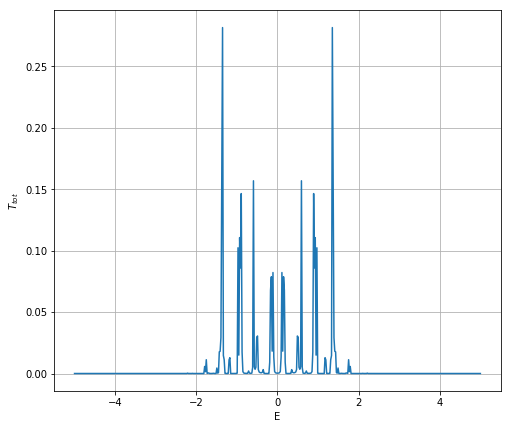

105


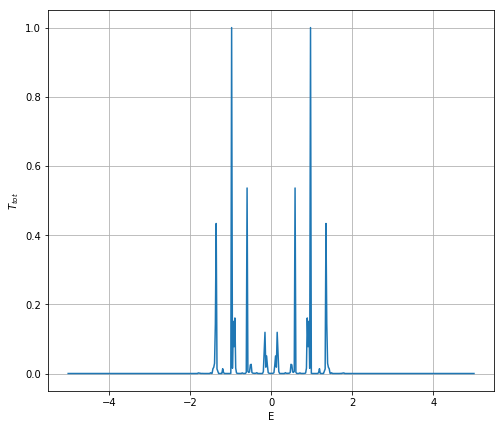

106


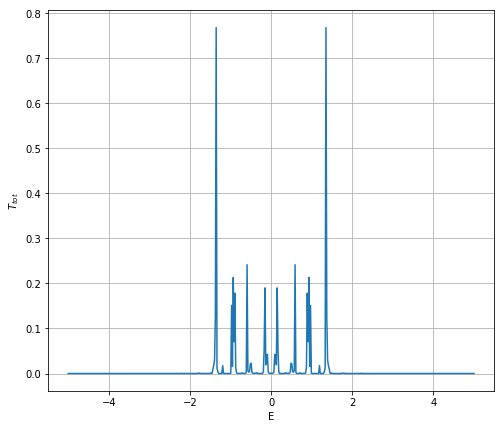

107


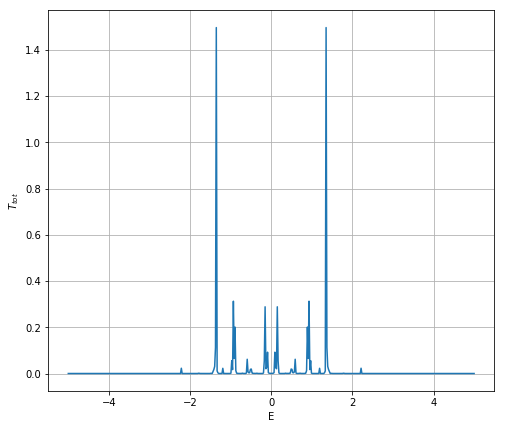

108


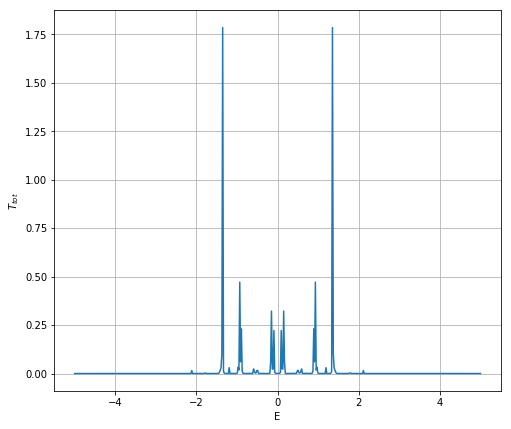

109


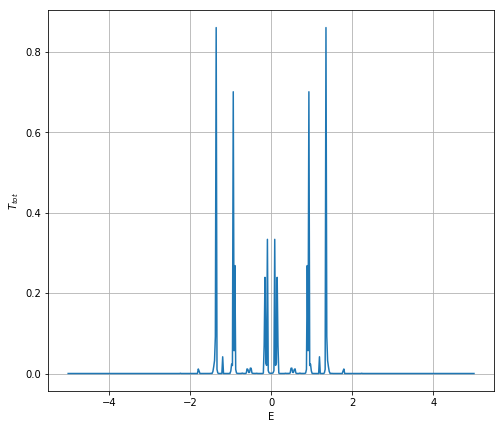

110


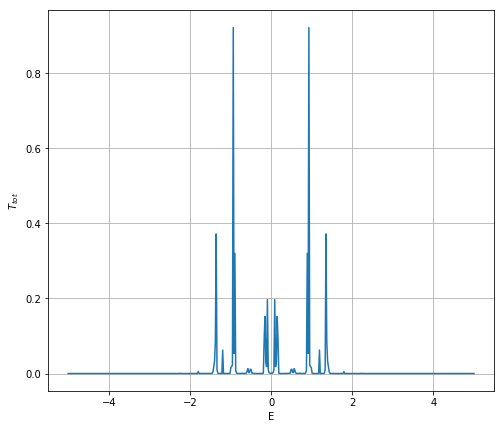

111


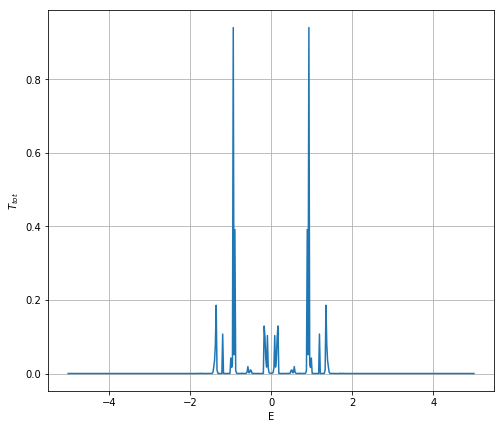

112


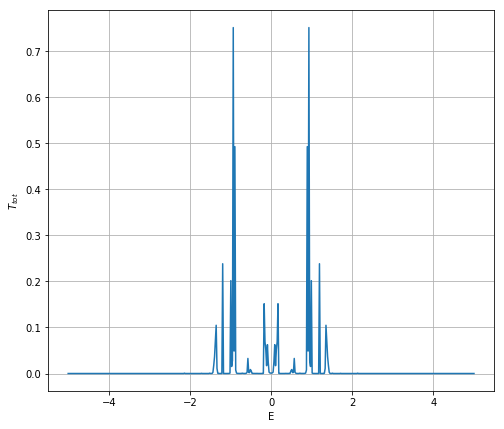

113


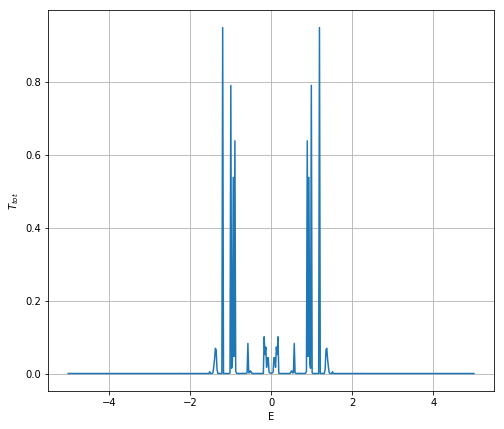

114


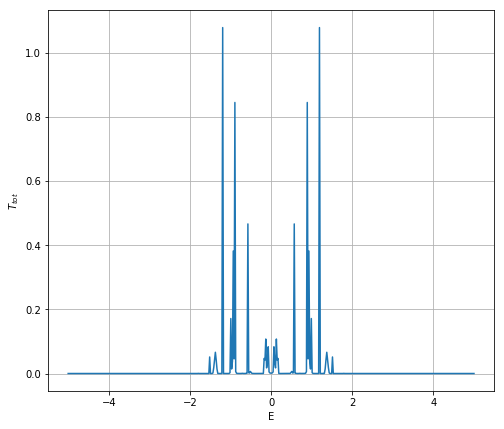

115


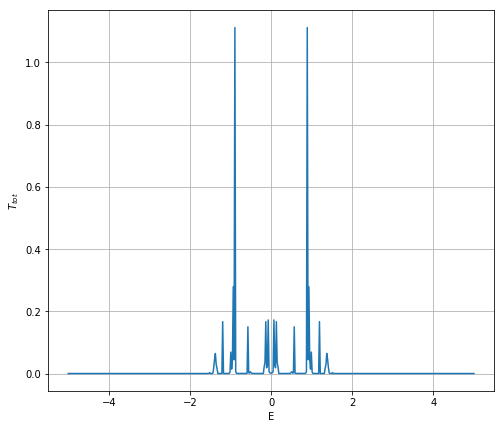

116


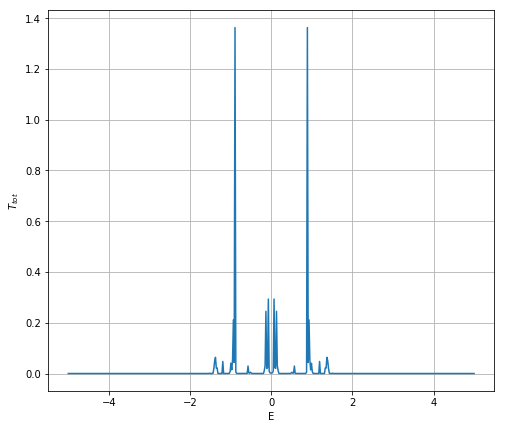

117


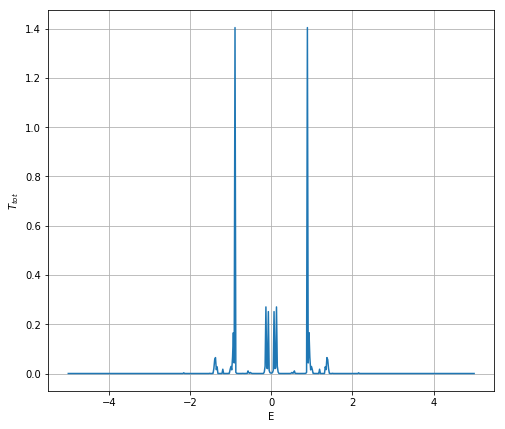

118


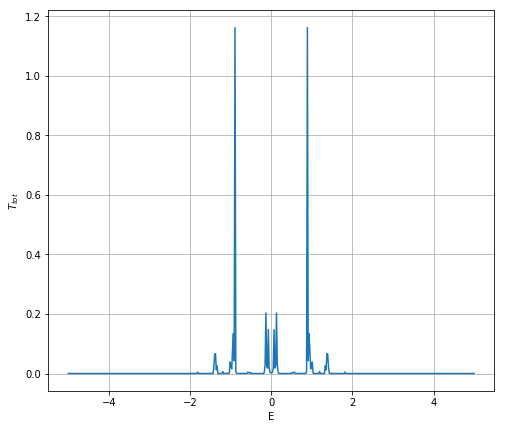

119


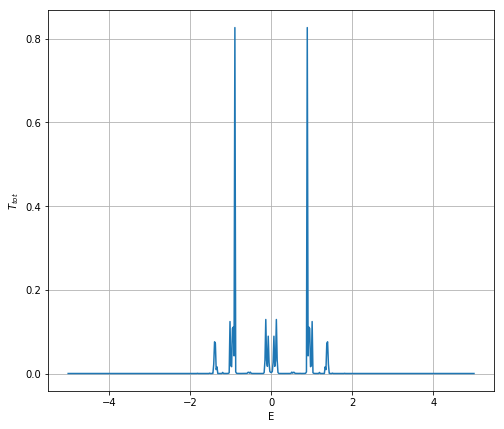

120


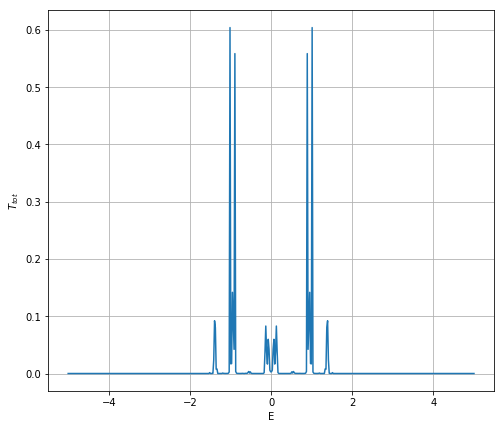

121


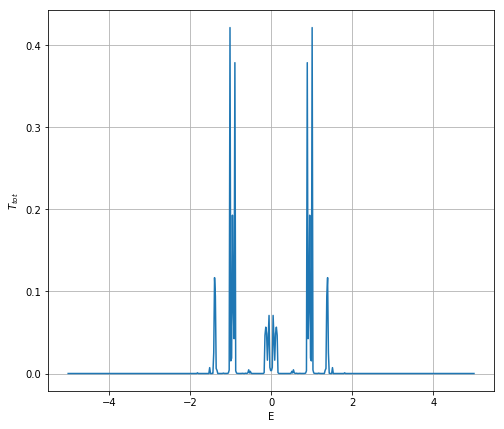

122


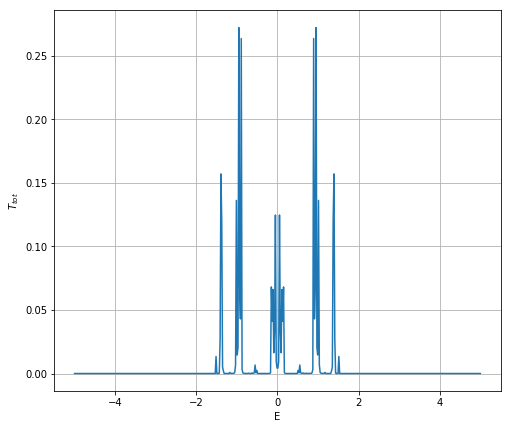

123


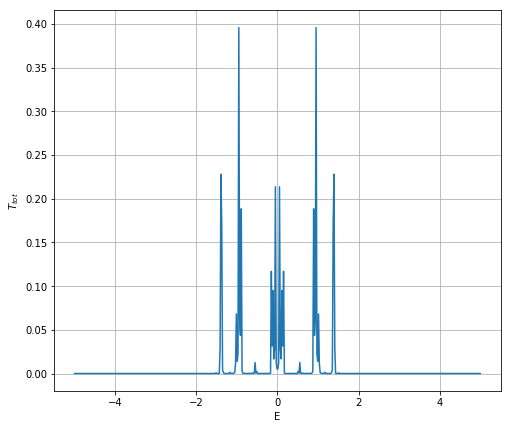

124


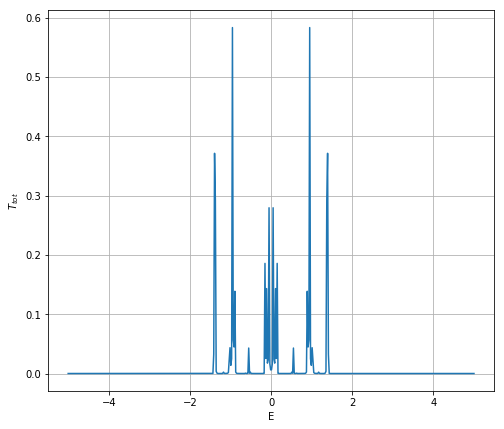

125


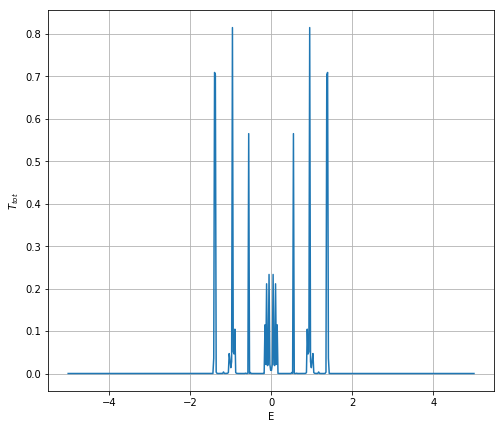

126


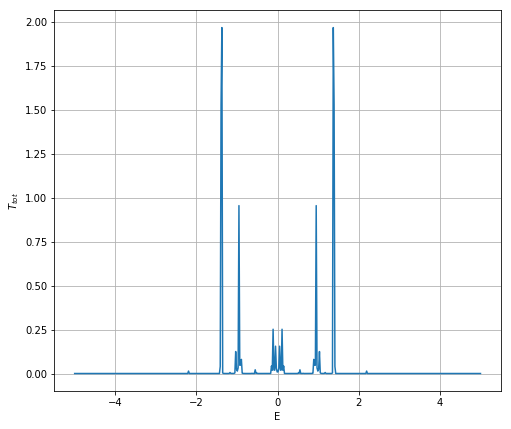

127


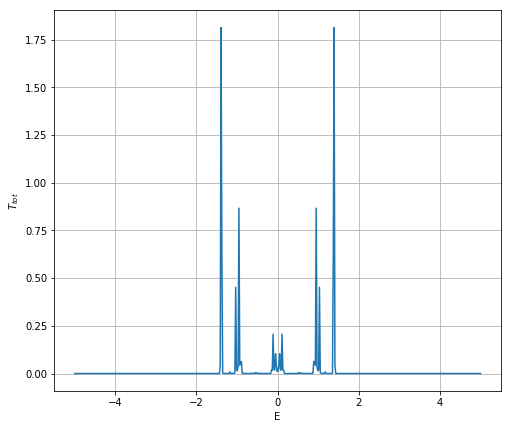

128


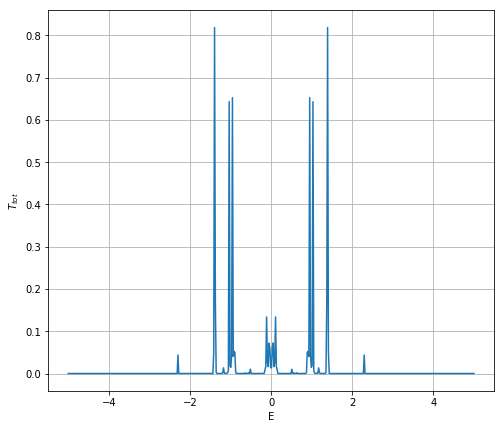

129


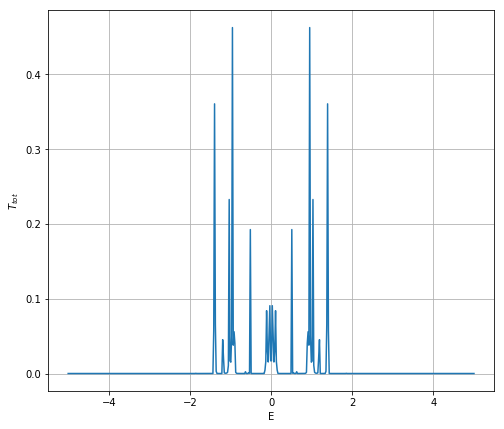

130


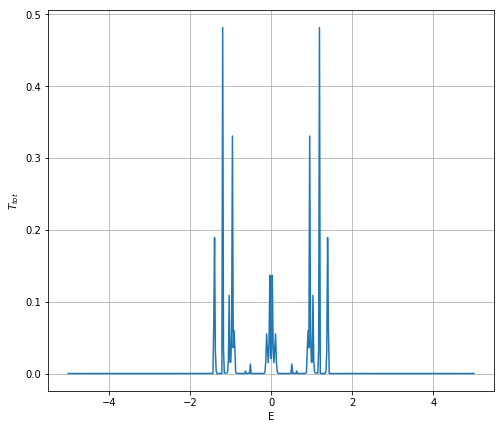

131


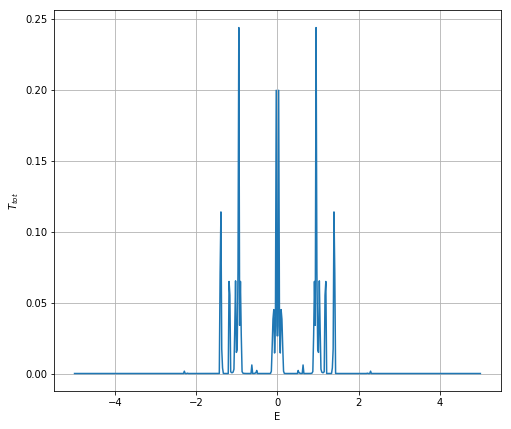

132


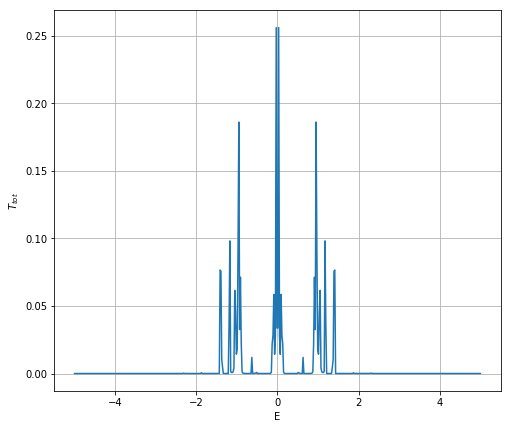

133


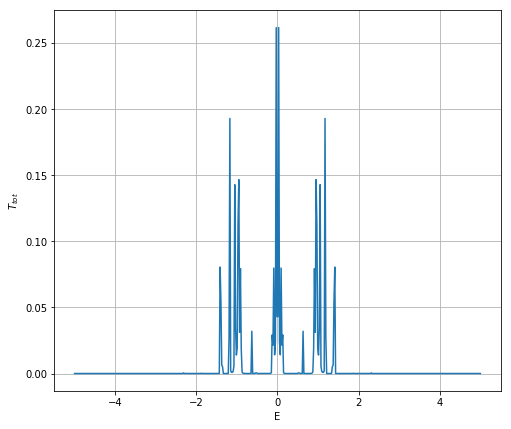

134


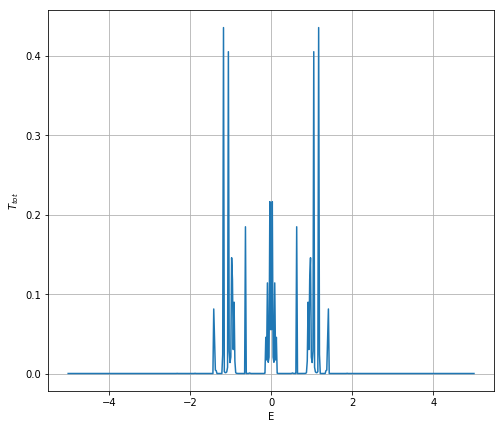

135


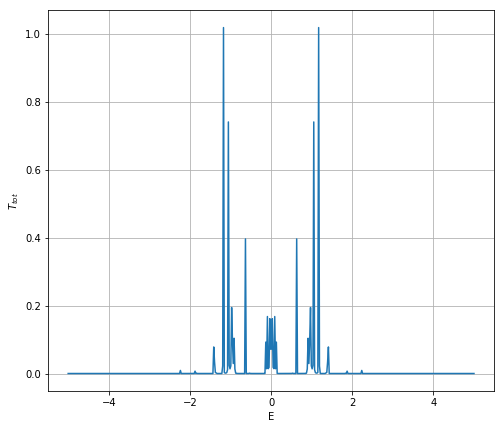

136


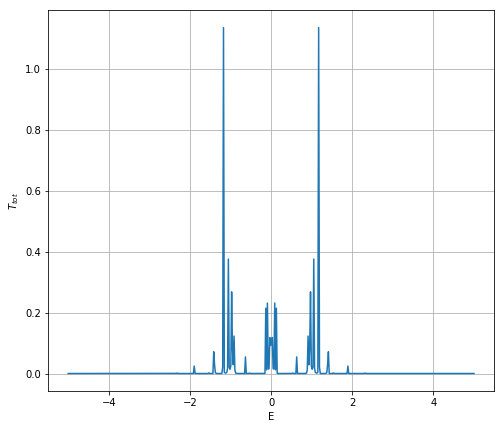

137


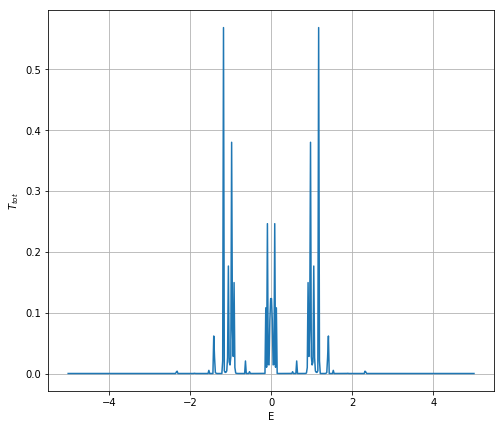

138


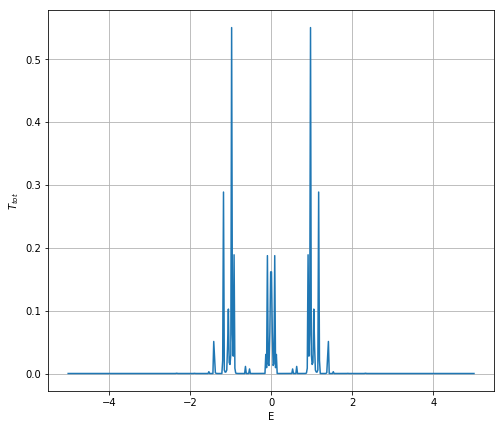

139


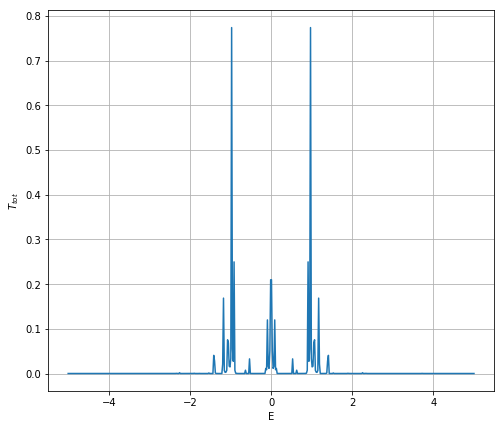

140


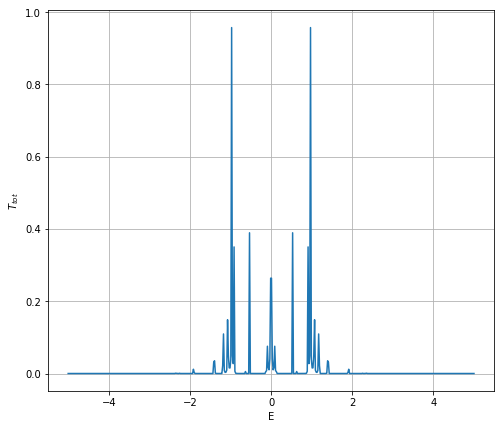

141


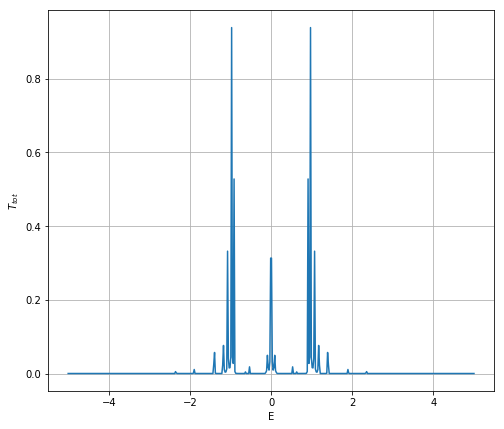

142


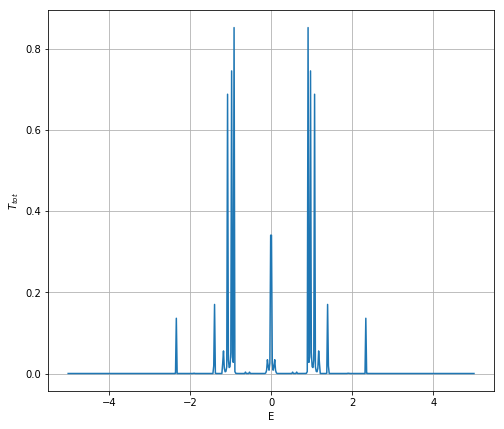

143


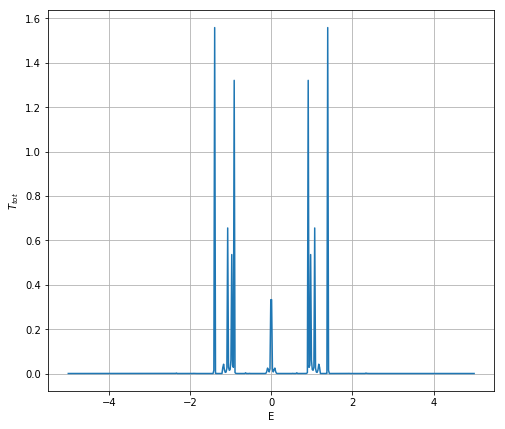

144


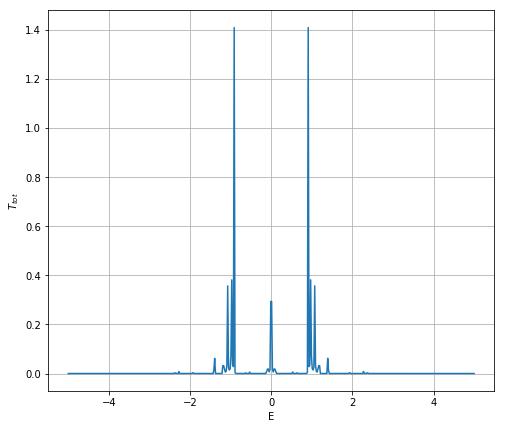

145


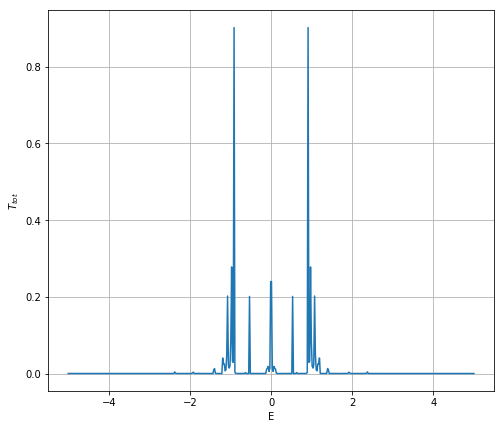

146


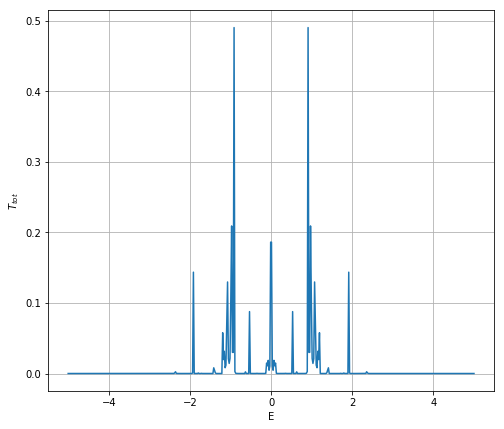

147


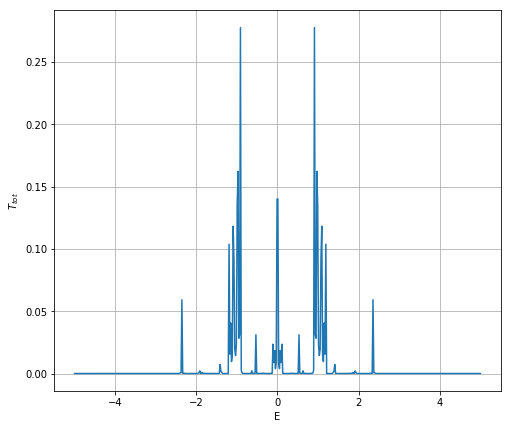

148


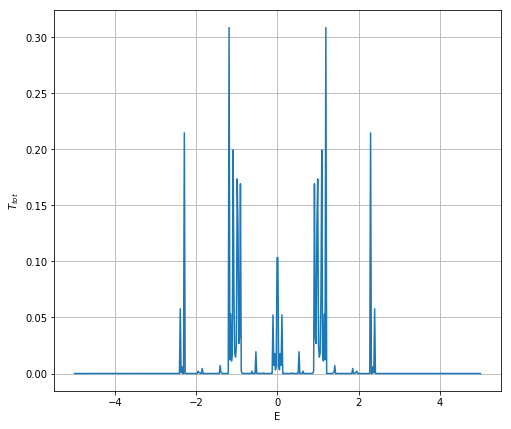

149


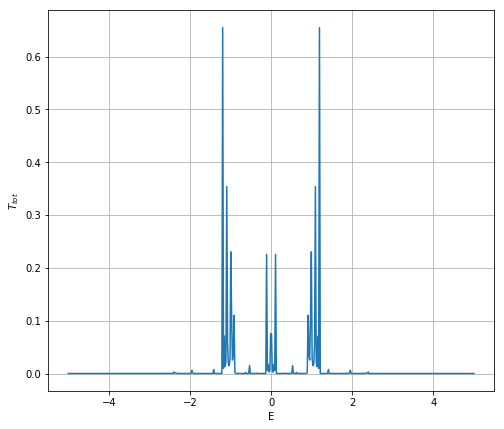

150


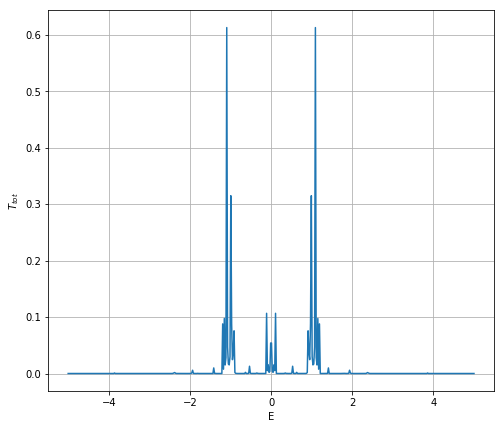

151


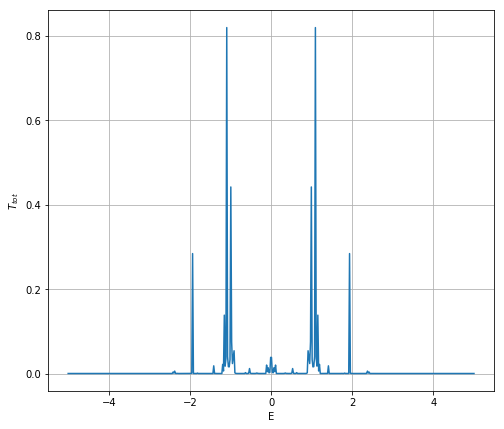

152


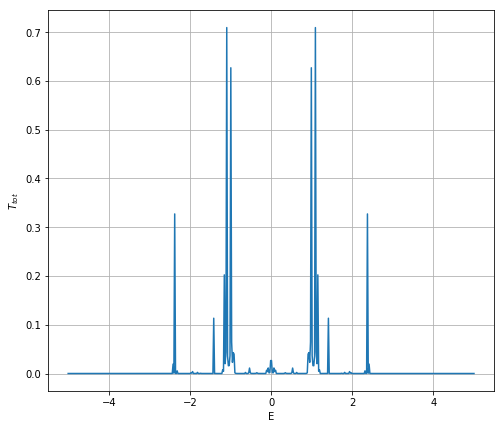

153


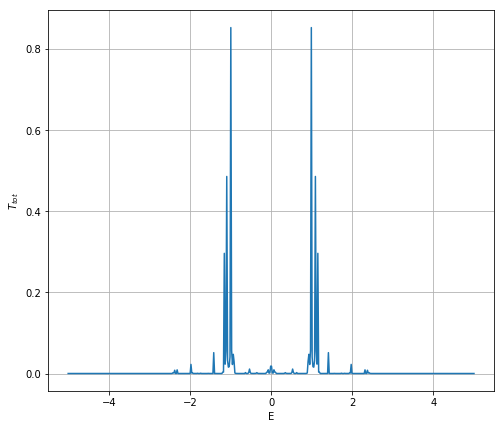

154


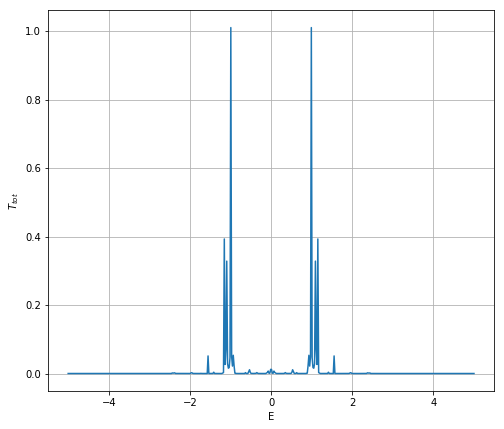

155


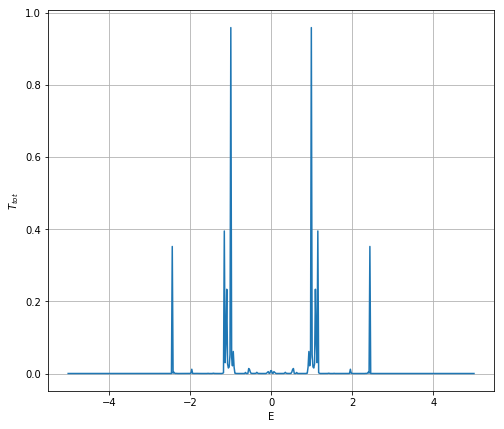

156


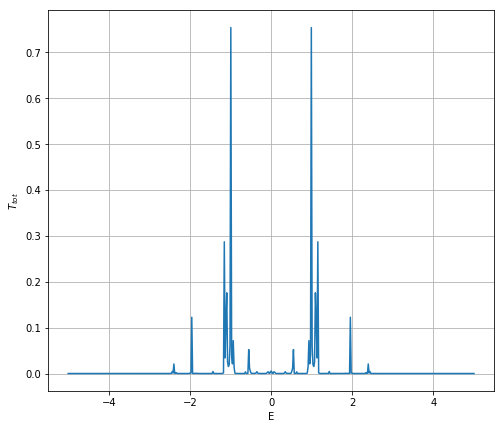

157


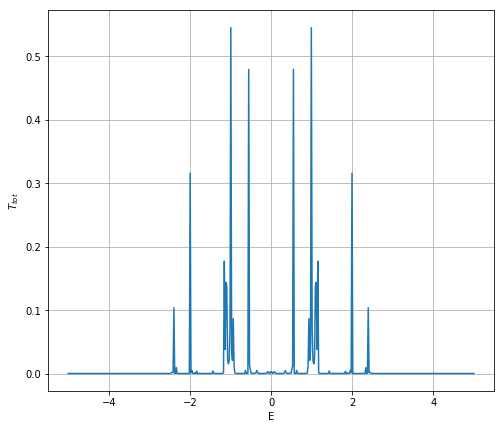

158


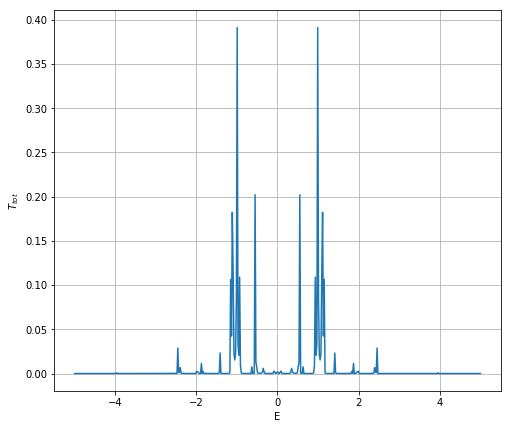

159


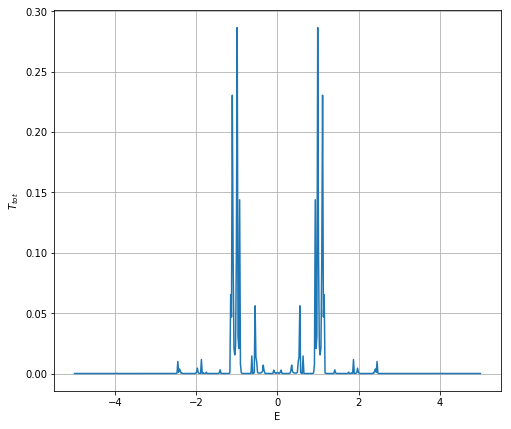

160


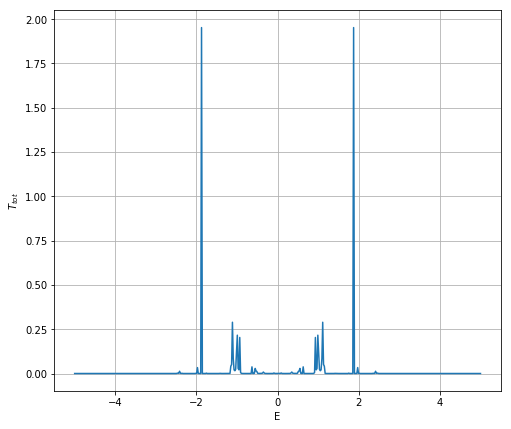

161


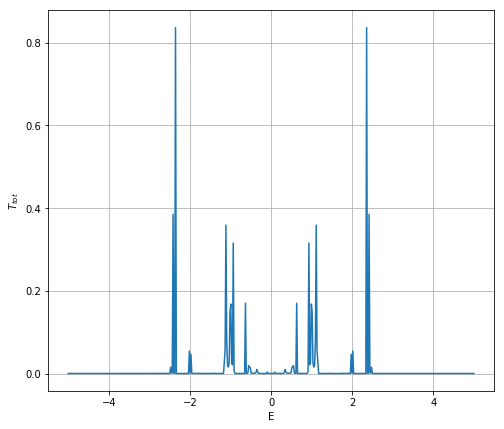

162


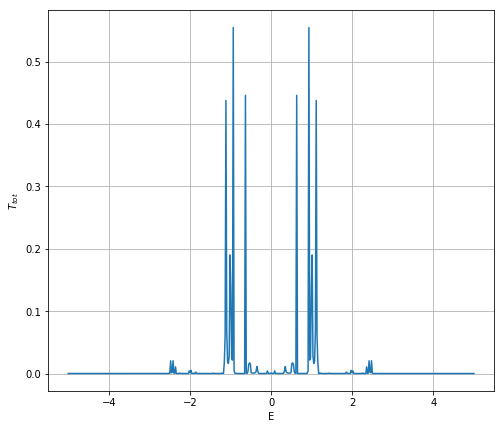

163


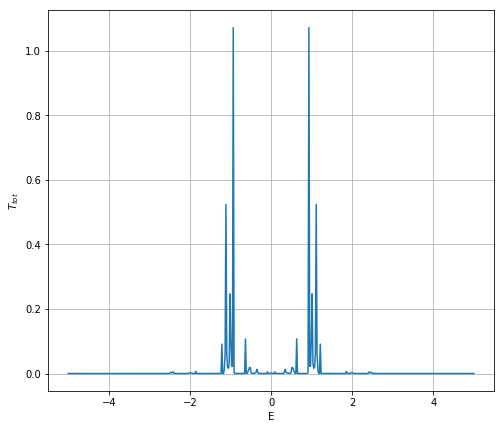

164


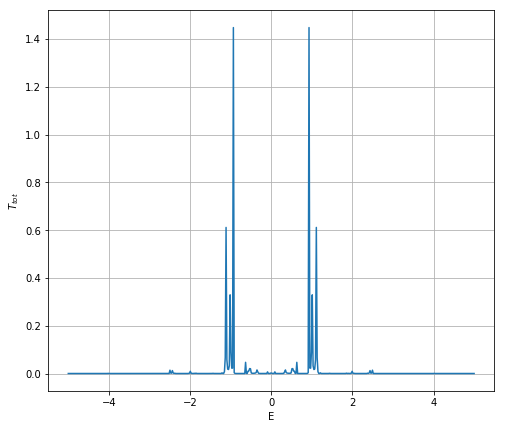

165


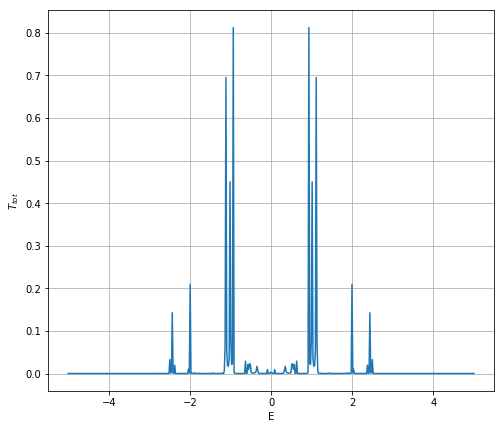

166


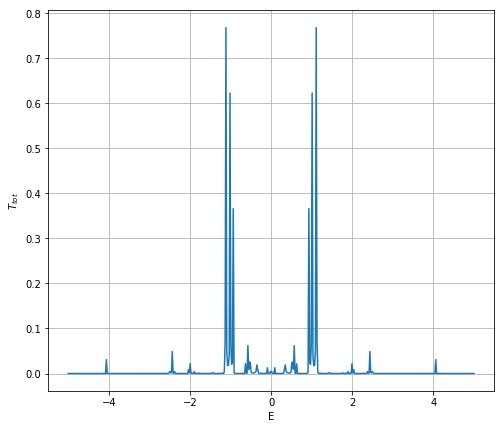

167


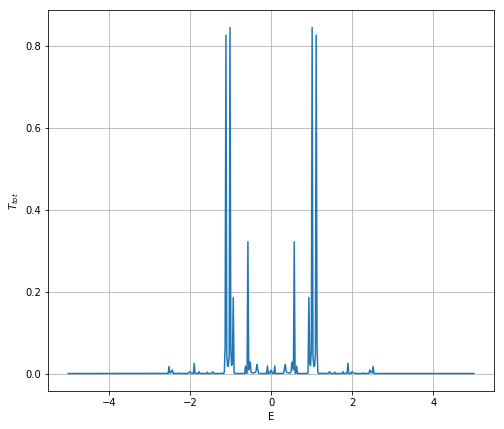

168


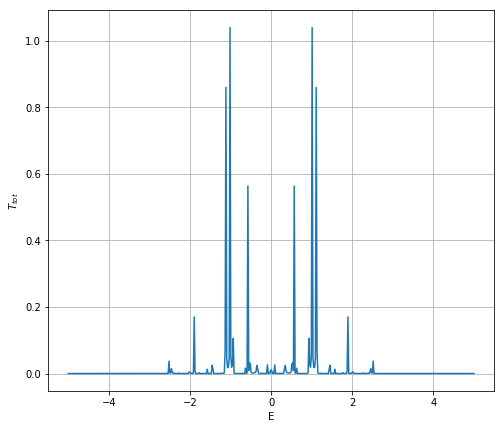

169


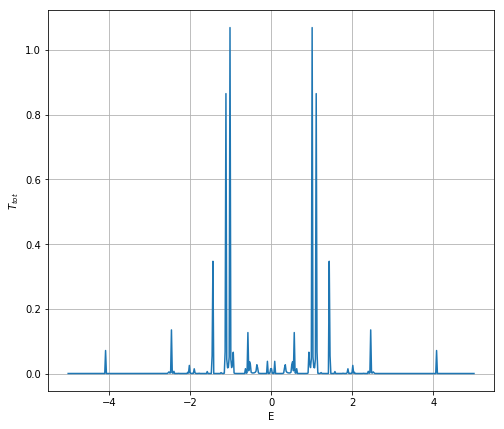

170


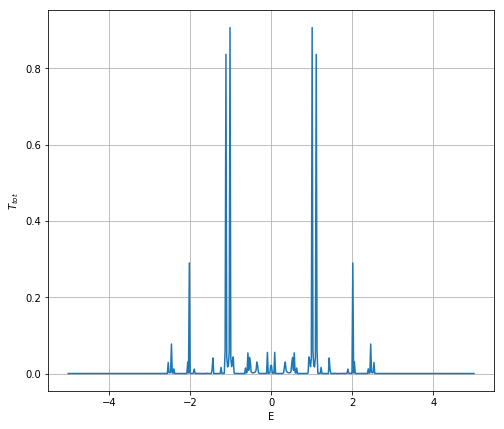

171


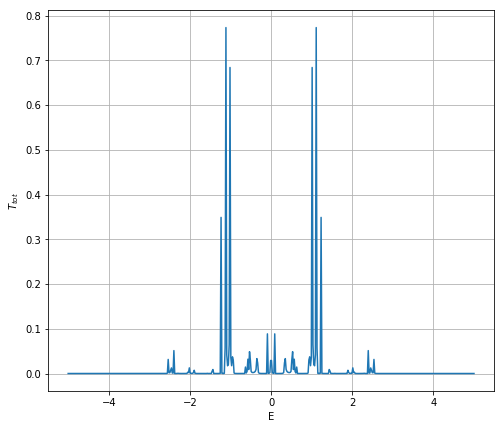

172


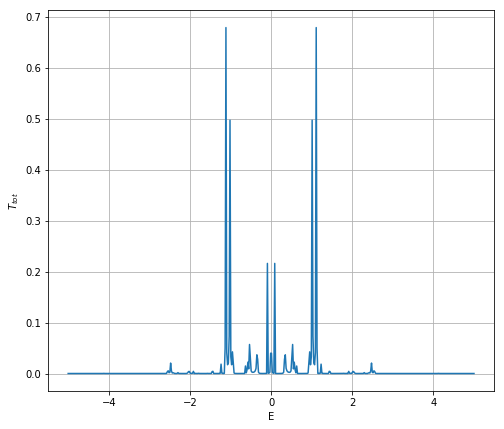

173


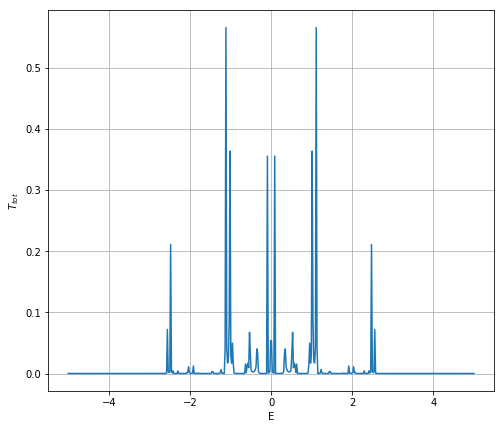

174


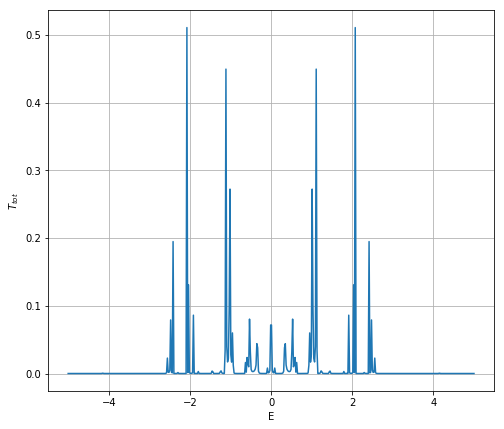

175


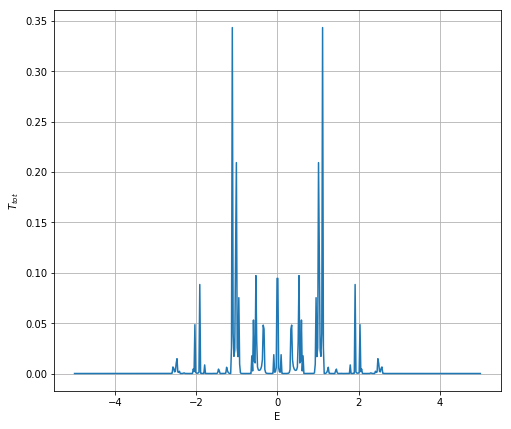

176


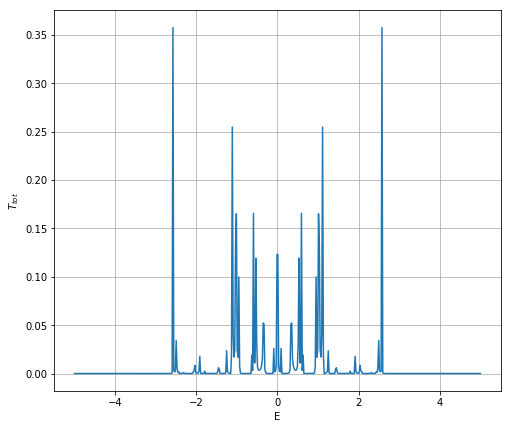

177


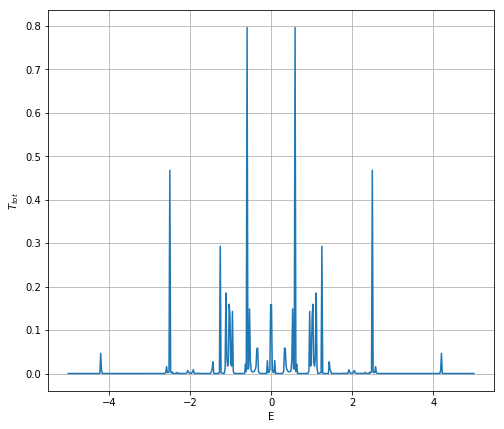

178


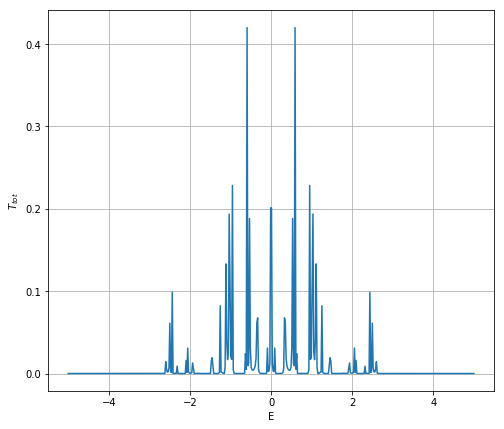

179


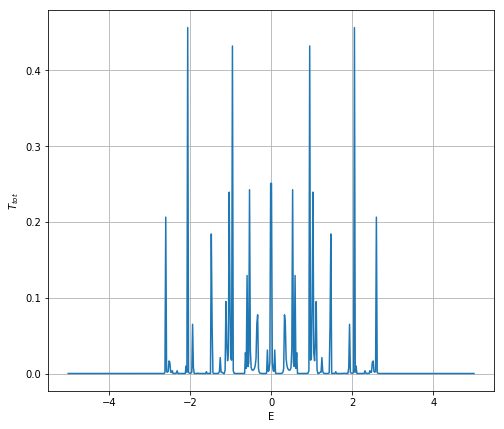

180


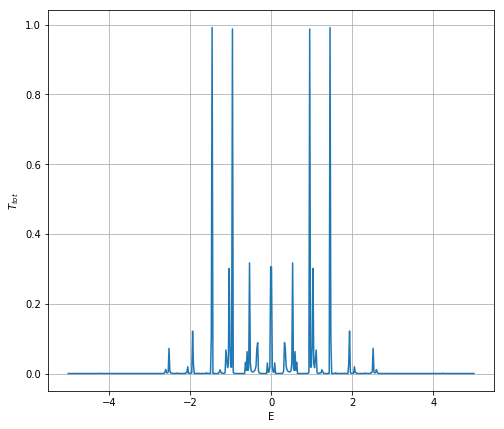

181


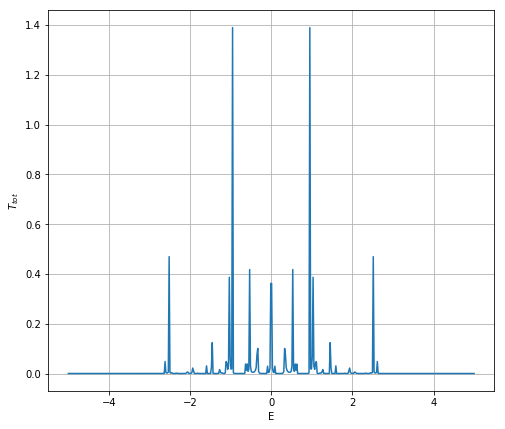

182


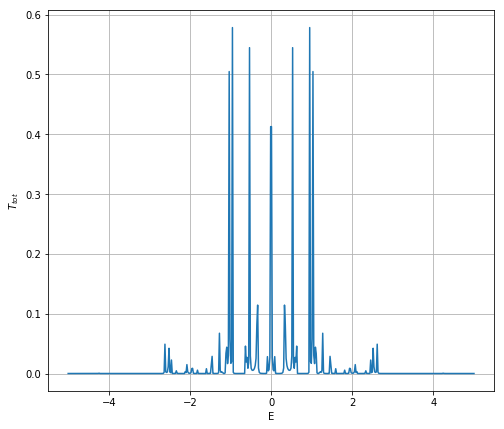

183


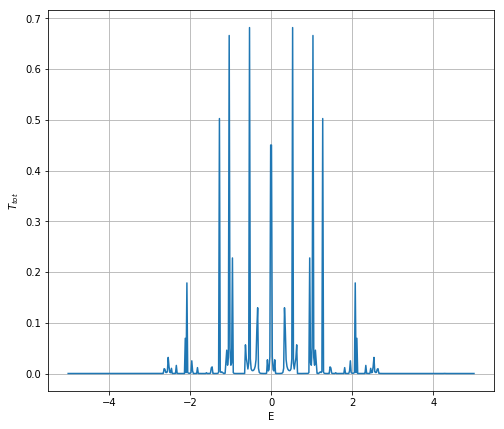

184


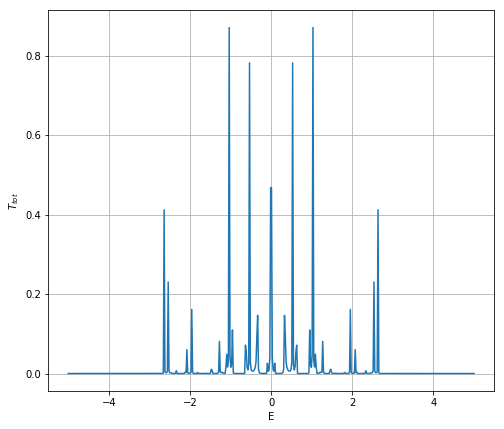

185


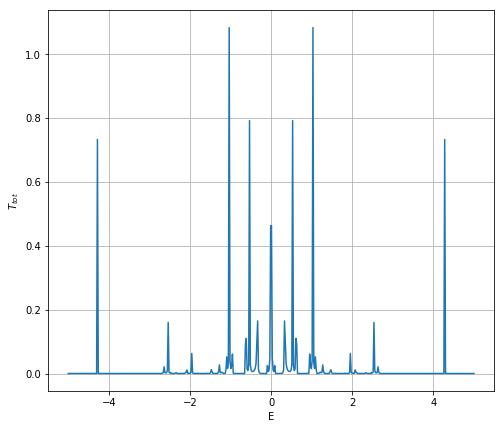

186


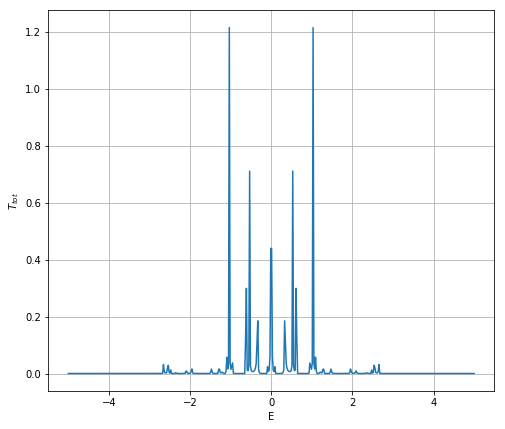

187


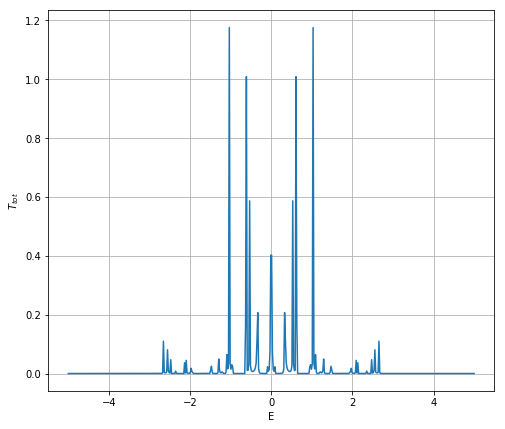

188


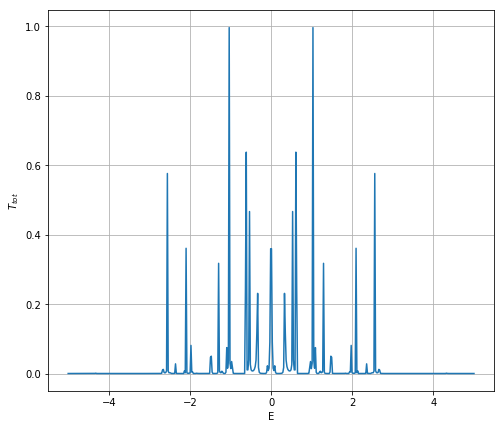

189


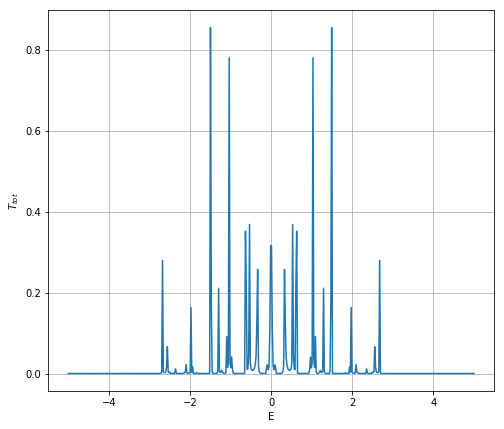

190


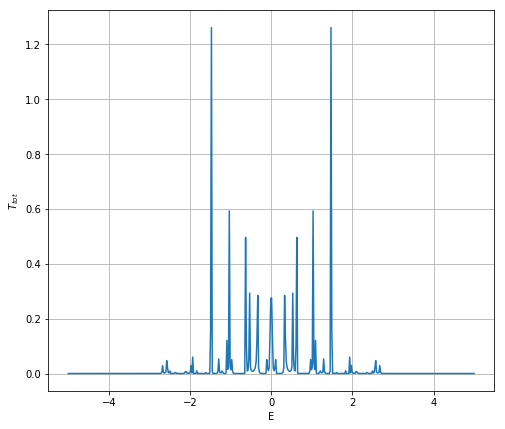

191


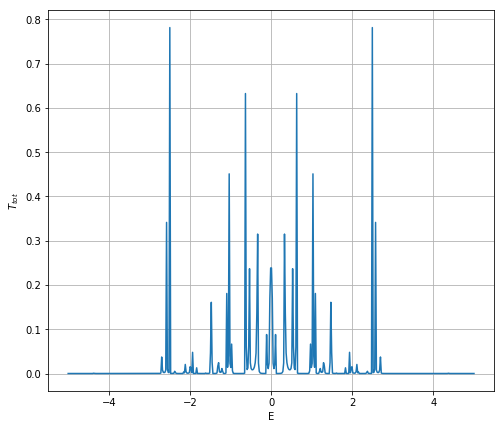

192


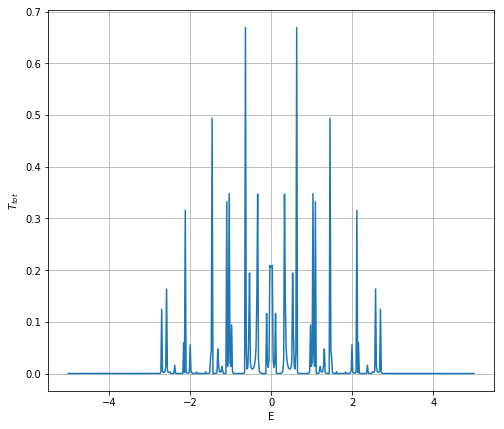

193


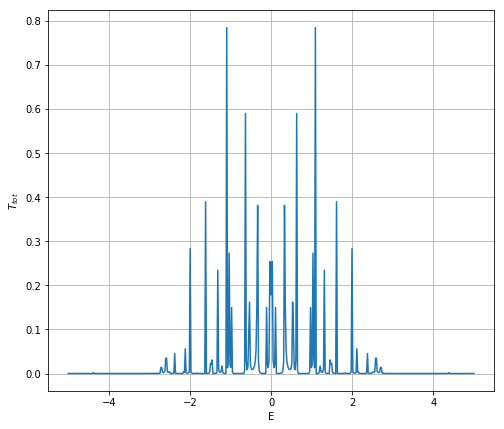

194


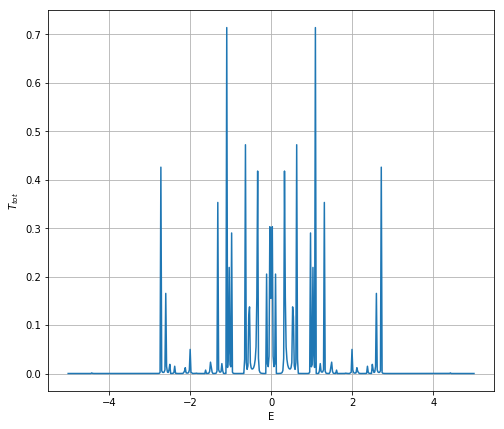

195


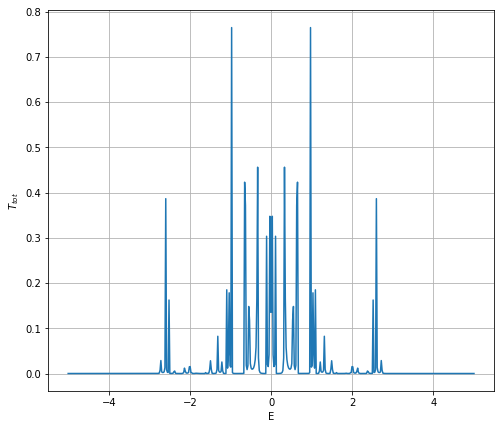

196


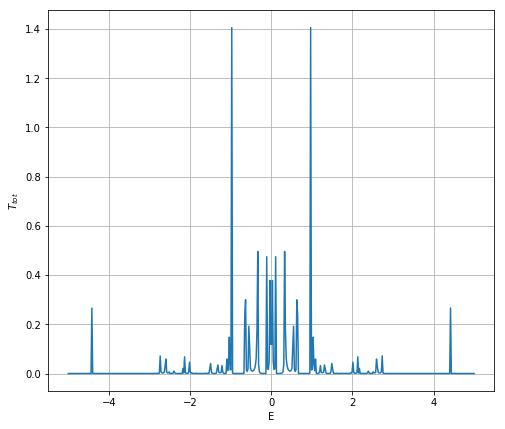

197


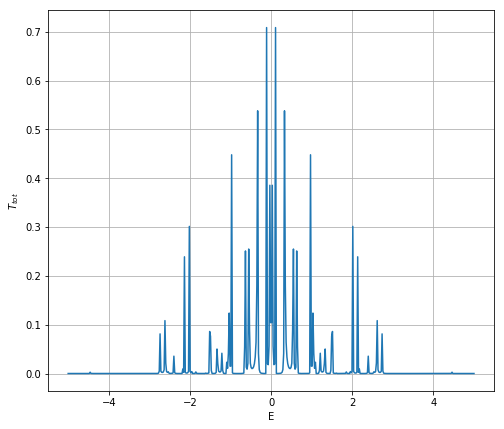

198


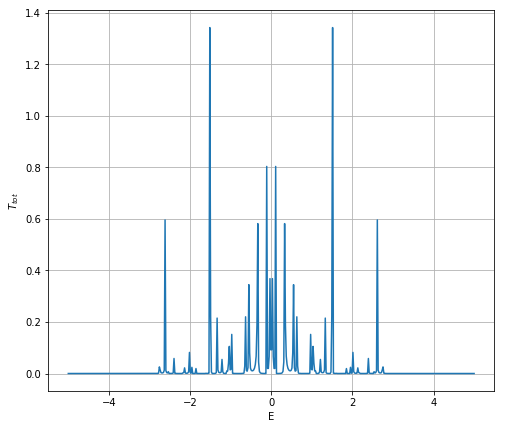

199


In [246]:
Pitch_arr = np.linspace(0,10,200)
E_const = np.array([1,0,1])
e_arr = np.linspace(-5,5,500)

Evals_store_sweep = np.zeros([len(Pitch_arr), 2*np.prod(Struct_mol_dims)])
T_pol_store_sweep = np.zeros([len(Pitch_arr), 4, len(e_arr)], dtype = 'complex128')
T_tot_store_sweep = np.zeros([len(Pitch_arr), len(e_arr)], dtype = 'complex128')

for j in range(0,len(Pitch_arr)):
    Pitch_i = Pitch_arr[j]
    Pos_arr = get_pos(Pitch_i)
    H0 = generate_H(Pos_arr, E_const)

    Hres = np.reshape(H0, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
    
    Evals_i = np.linalg.eig(Hres)[0]
    Evals_store_sweep[j] = Evals_i

    T_store = np.zeros([len(e_arr)])
    T_pol_store = np.zeros([4,len(e_arr)])


    for i in range(0,len(e_arr)):
        G_ret_res = np.linalg.inv((e_arr[i] + 0.0000000j)*np.eye(Hres.shape[0], Hres.shape[1]) - Hres - Sigma_tot_res)
        G_adv_res = np.conj(np.transpose(G_ret_res))
        T_tot = np.trace(np.dot(Gamma_L_res, np.dot(G_ret_res, np.dot(Gamma_R_res, G_adv_res))))
        T_store[i] = T_tot

        Ti_down = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_down,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_down,G_adv_res))))))
        Ti_up = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_up,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_up,G_adv_res))))))
        Ti_du = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_up,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_down,G_adv_res))))))
        Ti_ud = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_down,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_up,G_adv_res))))))

        T_pol_store[:,i] = np.array([Ti_down, Ti_up, Ti_du, Ti_ud])

        #print(Ti_down + Ti_up + Ti_du + Ti_ud - T_tot)
        #print((-Ti_down + Ti_up + Ti_du - Ti_ud)/ T_tot)

    T_pol_store_sweep[j] = T_pol_store
    T_tot_store_sweep[j] = T_store
    
    plt.figure(figsize = (8,7))
    plt.plot(e_arr, T_store)
    plt.xlabel('E');plt.ylabel(r'$T_{tot}$')
    plt.grid()
    plt.show()
    
    print(j)
    
T_SPT_sweep = (T_pol_store_sweep[:,1] + T_pol_store_sweep[:,2] - T_pol_store_sweep[:,0] - T_pol_store_sweep[:,3])/T_tot_store_sweep

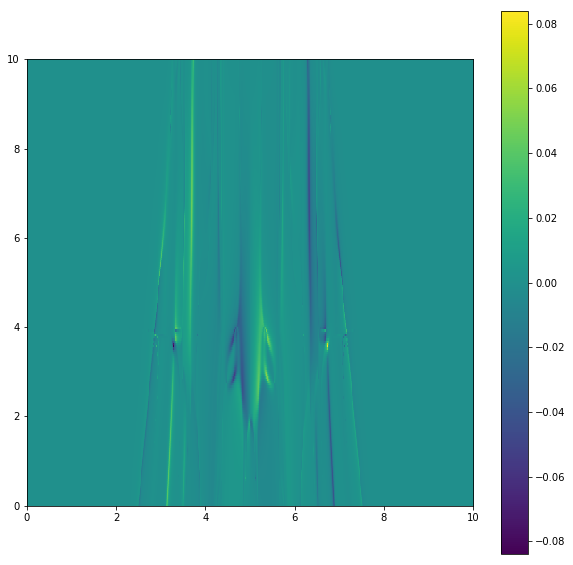

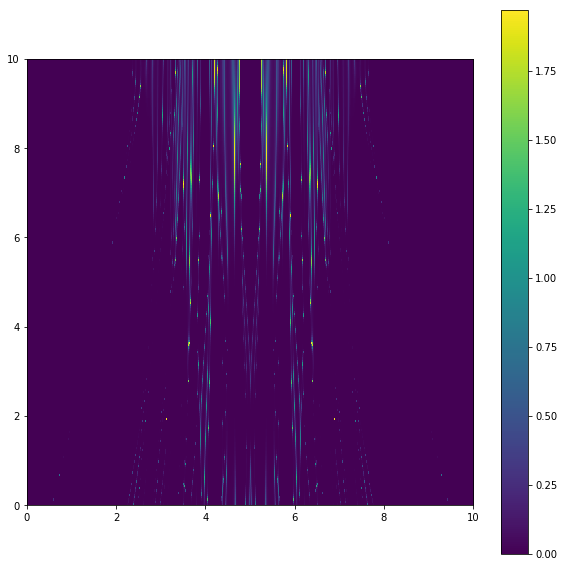

In [247]:
plt.figure(figsize = (10,10))
plt.imshow(np.real(T_SPT_sweep)[:,:], extent = [0,10,0,10]);plt.colorbar();plt.show()
plt.figure(figsize = (10,10))
plt.imshow(np.real(T_tot_store_sweep)[:,:], extent = [0,10,0,10]);plt.colorbar();plt.show()

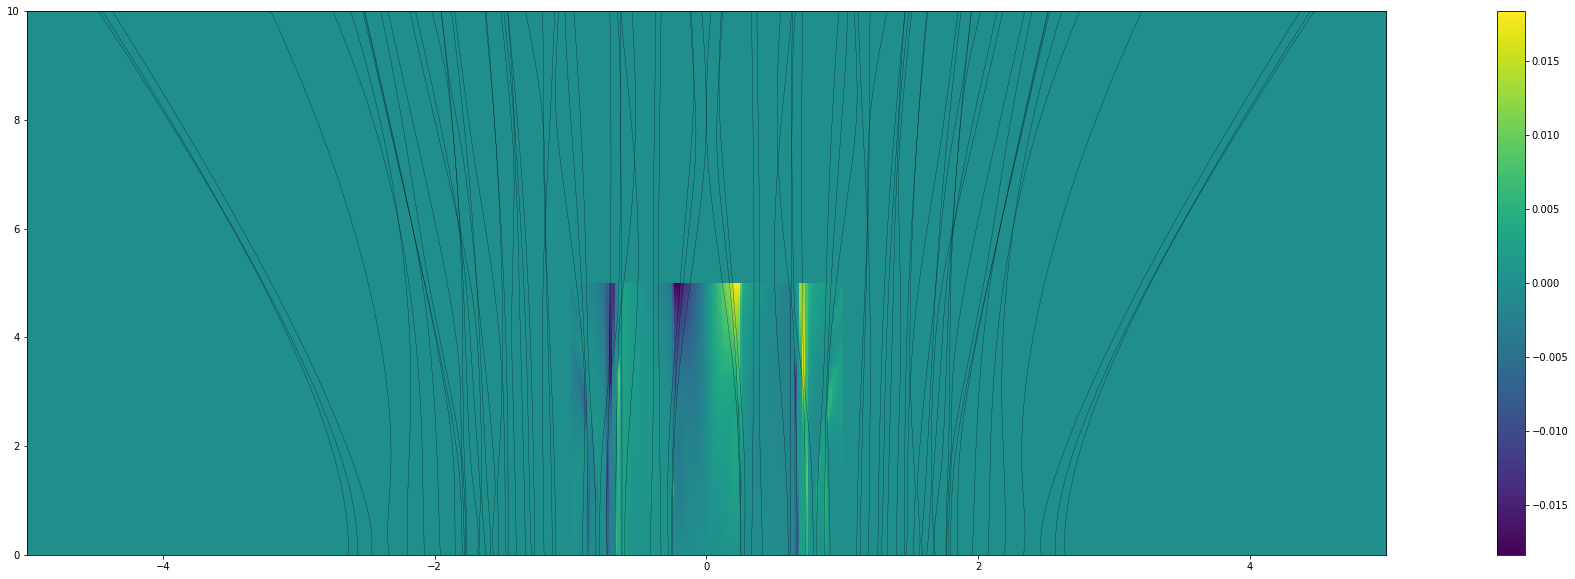

C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


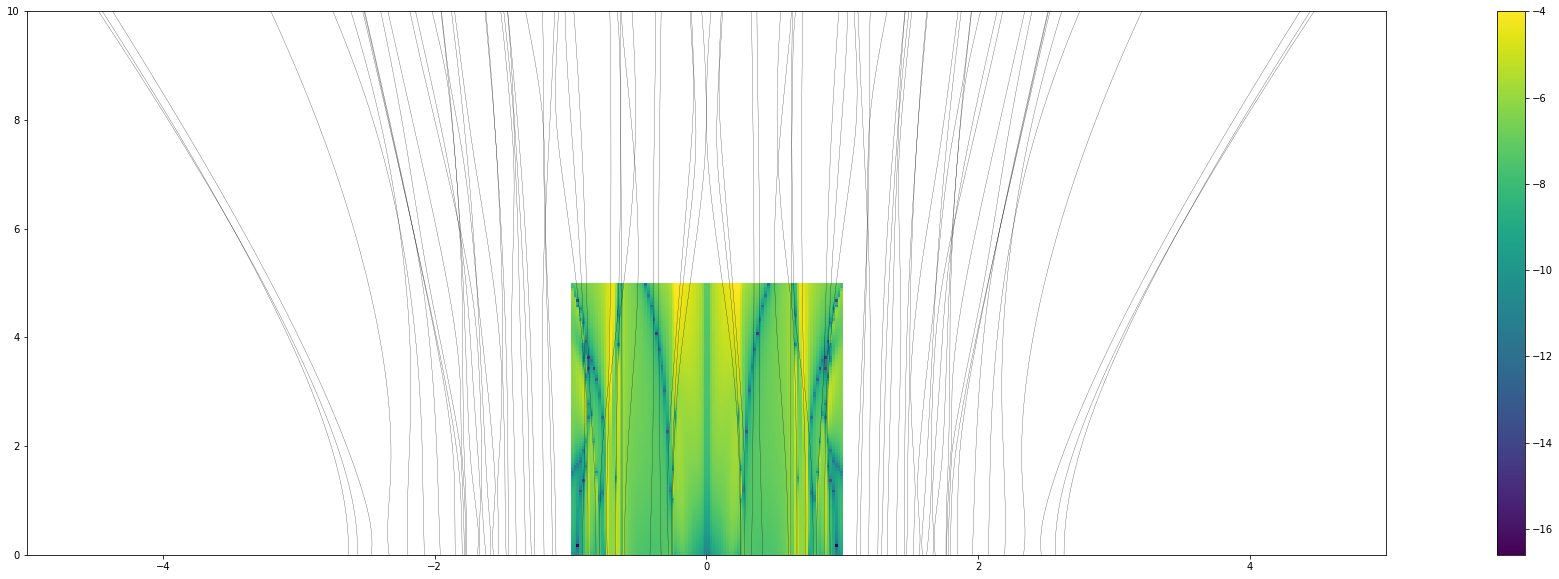

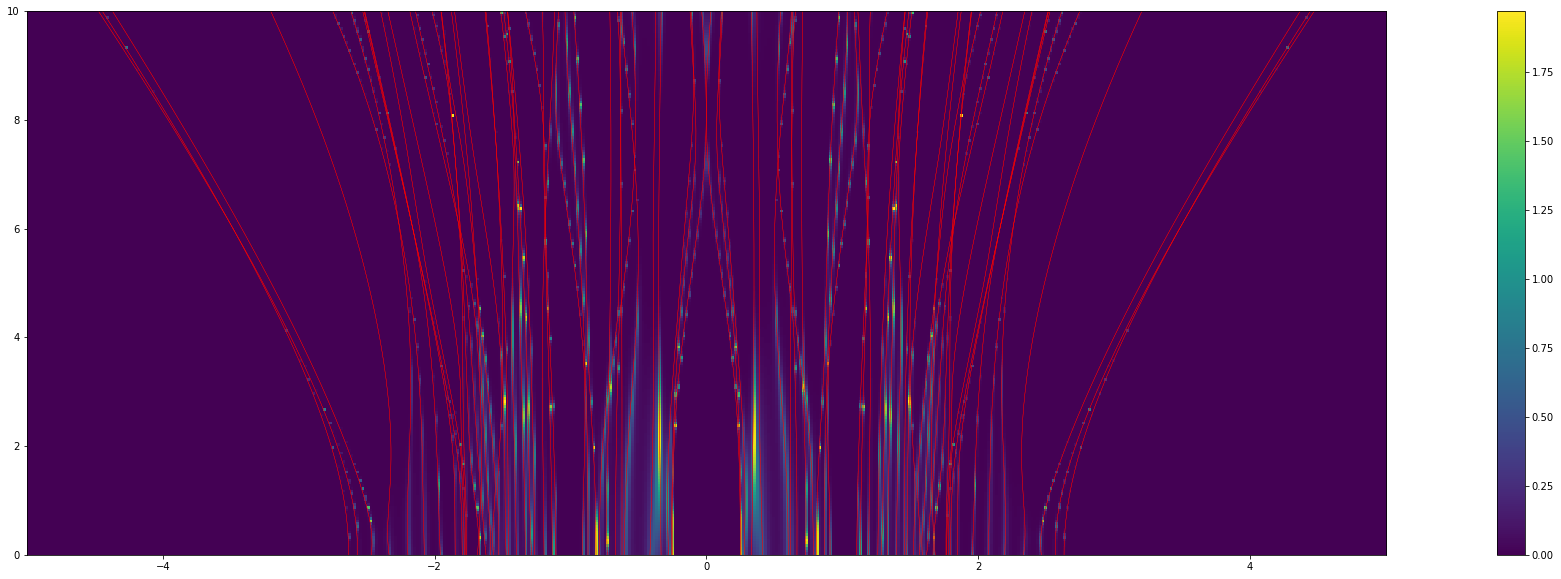

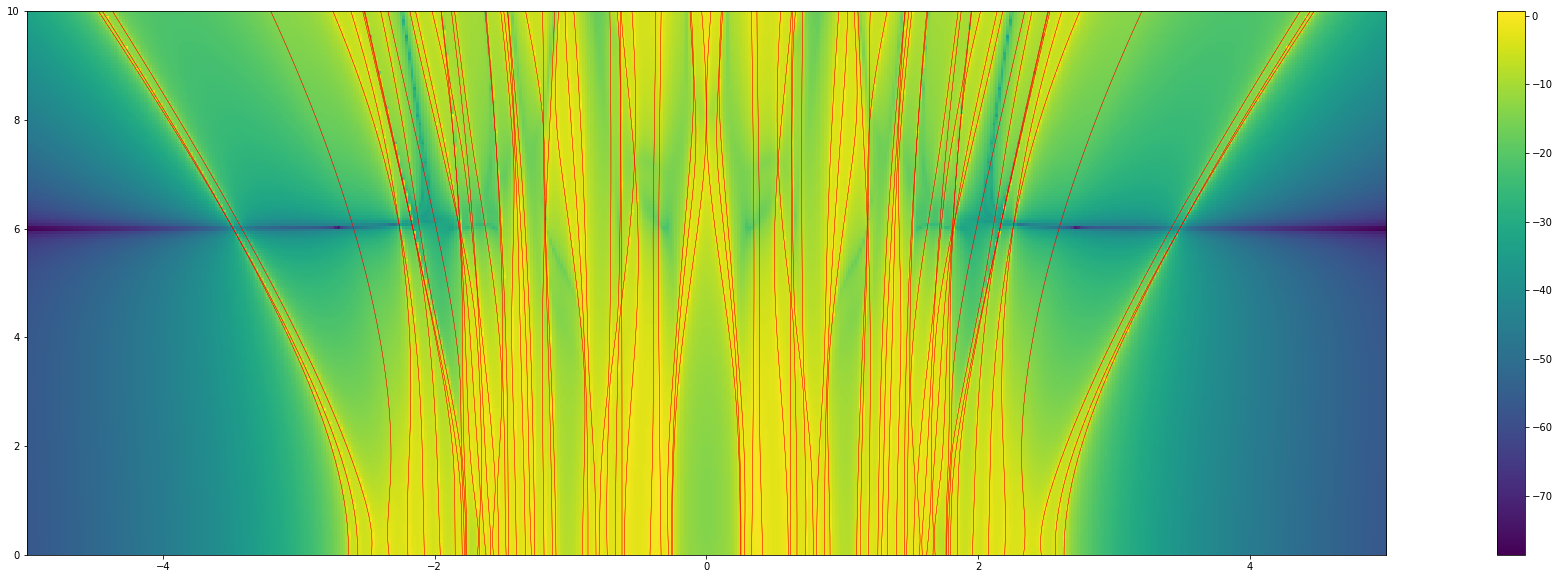

In [282]:
Plot_SPT = np.zeros(T_SPT_sweep.shape, dtype = 'complex128')
Evals_store_sort = np.sort(np.real(Evals_store_sweep), axis = 1)

p_bound1, p_bound2 = 0,100
e_bound1, e_bound2 = 200,300
Plot_SPT[p_bound1:p_bound2,e_bound1:e_bound2] = T_SPT_sweep[p_bound1:p_bound2,e_bound1:e_bound2]

Ratio_fig = 0.4


plt.figure(figsize = (40,10))
plt.imshow(np.flip(np.real(Plot_SPT)[:,:], axis = 0), extent = [np.min(e_arr),np.max(e_arr),np.min(Pitch_arr),np.max(Pitch_arr)], aspect = Ratio_fig*(np.max(e_arr) - np.min(e_arr))/(np.max(Pitch_arr) - np.min(Pitch_arr)));plt.colorbar();

for i in range(0,Evals_store_sweep.shape[1]):
    plt.plot(Evals_store_sort[:,i],Pitch_arr, color= (0,0,0,0.5), linewidth  = 0.25)

plt.show()

plt.figure(figsize = (40,10))

plt.imshow(np.flip(np.log(np.abs(Plot_SPT))[:,:], axis = 0), extent = [np.min(e_arr),np.max(e_arr),np.min(Pitch_arr),np.max(Pitch_arr)], aspect = Ratio_fig*(np.max(e_arr) - np.min(e_arr))/(np.max(Pitch_arr) - np.min(Pitch_arr)));plt.colorbar();

for i in range(0,Evals_store_sweep.shape[1]):
    plt.plot(Evals_store_sort[:,i],Pitch_arr, color= (0,0,0,0.5), linewidth = 0.25)

plt.show()
plt.figure(figsize = (40,10))
plt.imshow(np.flip(np.real(T_tot_store_sweep)[:,:], axis = 0), extent = [np.min(e_arr),np.max(e_arr),np.min(Pitch_arr),np.max(Pitch_arr)], aspect = Ratio_fig*(np.max(e_arr) - np.min(e_arr))/(np.max(Pitch_arr) - np.min(Pitch_arr)));plt.colorbar();
for i in range(0,Evals_store_sweep.shape[1]):
    plt.plot(Evals_store_sort[:,i],Pitch_arr, color= (1,0,0,1), linewidth  = 0.35)

plt.show()

plt.figure(figsize = (40,10))
plt.imshow(np.flip(np.log(np.abs(T_tot_store_sweep))[:,:], axis = 0), extent = [np.min(e_arr),np.max(e_arr),np.min(Pitch_arr),np.max(Pitch_arr)], aspect = Ratio_fig*(np.max(e_arr) - np.min(e_arr))/(np.max(Pitch_arr) - np.min(Pitch_arr)));plt.colorbar();
for i in range(0,Evals_store_sweep.shape[1]):
    plt.plot(Evals_store_sort[:,i],Pitch_arr, color= (1,0,0,1), linewidth  = 0.35)

plt.show()

In [218]:
a=1
def ftest(a):
    print(ftest2(a))
    
def ftest2(b):
    return b + a

ftest(1)

2


(50, 160)


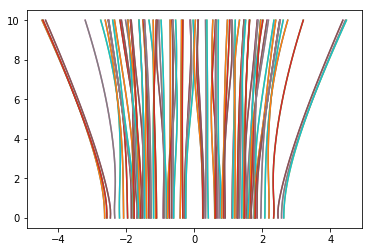

In [229]:
Evals_store_sort = np.sort(np.real(Evals_store_sweep), axis = 1)
print(Evals_store_sort.shape)
Evals_store_sort[0]

for i in range(0,Evals_store_sweep.shape[1]):
    plt.plot(Evals_store_sort[:,i],Pitch_arr)


In [217]:
np.sort?

In [215]:
np.sort(np.random.random(10)-0.5)

array([-0.40191842, -0.27689771, -0.25821018,  0.05566358,  0.10713349,
        0.15840732,  0.15997909,  0.2000651 ,  0.20906079,  0.37082218])

In [3]:
A = np.arange(0,10)

In [5]:
A[::5]

array([0, 5])